# Notebook to implement pattern-based disaggregation/load profiling as an alternative forecasting method

In [2]:
import pandas as pd
import numpy as np
from prophet import Prophet
import glob
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
# Load all household data files into a dictionary
def load_household_data():
    # Get all CSV files from household_data directory
    csv_files = glob.glob("../../../../data/household_data/*.csv")
    
    household_dict = {}
    
    for file_path in csv_files:
        # Extract user ID from filename
        filename = os.path.basename(file_path)
        user_id = filename.replace('user_data_', '').replace('.csv', '')
        
        # Load CSV and store in dictionary
        df = pd.read_csv(file_path)
        
        # Resample to hourly frequency using sums
        df['datetime'] = pd.to_datetime(df['datetime'])
        df = df.set_index('datetime')
        
        # drop status column if it exists
        df.drop("status", axis=1, inplace=True, errors='ignore')
        
        # Resample numeric columns (value) to hourly frequency using sum
        df_hourly = df[['value']].resample('h').sum()
        
        # Filter out incomplete days (days with less than 24 hours of data)
        # Group by date and count hours per day
        df_hourly_reset = df_hourly.reset_index()
        df_hourly_reset['date'] = df_hourly_reset['datetime'].dt.date
        
        # Count hours per day and identify complete days (24 hours)
        hours_per_day = df_hourly_reset.groupby('date').size()
        complete_days = hours_per_day[hours_per_day == 24].index
        
        # Filter to keep only complete days
        df_hourly_filtered = df_hourly_reset[df_hourly_reset['date'].isin(complete_days)].copy()
        
        # Drop the temporary date column and set datetime back as index if needed
        df_hourly_filtered = df_hourly_filtered.drop('date', axis=1)
        
        # Reset index to have datetime as a column again
        household_dict[user_id] = df_hourly_filtered
        
        print(f"User {user_id}: {len(df_hourly_reset)} total hours -> {len(df_hourly_filtered)} hours ({len(complete_days)} complete days)")
    
    print(f"Loaded {len(household_dict)} household datasets (resampled to hourly frequency, incomplete days filtered)")
    return household_dict

# Load the household data
household_data = load_household_data()

User 27665: 8785 total hours -> 8784 hours (366 complete days)
User 35467: 8785 total hours -> 8784 hours (366 complete days)
User 9774: 8785 total hours -> 8784 hours (366 complete days)
User 37728: 8785 total hours -> 8784 hours (366 complete days)
User synthetic_1_person_household: 8784 total hours -> 8784 hours (366 complete days)
User 10625: 8785 total hours -> 8784 hours (366 complete days)
User 47755: 8785 total hours -> 8784 hours (366 complete days)
User 26801: 8785 total hours -> 8784 hours (366 complete days)
User 62262: 8785 total hours -> 8784 hours (366 complete days)
User 62464: 8785 total hours -> 8784 hours (366 complete days)
User 73025: 8785 total hours -> 8784 hours (366 complete days)
User 16681: 8785 total hours -> 8784 hours (366 complete days)
User 81516: 8785 total hours -> 8784 hours (366 complete days)
User 68413: 8785 total hours -> 8784 hours (366 complete days)
User 57393: 8785 total hours -> 8784 hours (366 complete days)
User 0.43: 8785 total hours -> 87

In [16]:
# Select 10 random households and split into train/validation
import random

# Set seed for reproducibility
random.seed(12)

# Select 10 random households
all_household_ids = list(household_data.keys())
selected_ids = random.sample(all_household_ids, min(10, len(all_household_ids)))

print(f"Selected {len(selected_ids)} households for analysis")

print(selected_ids)

# Split each household into training and validation
train_data = {}
validation_data = {}

total_days = 210
training_days = 180
validation_days = 30

for household_id in selected_ids:
    df = household_data[household_id]
    

    #take the most recent 210 days from the data
    selected_df = df.iloc[-(total_days*24):].copy()

    # Split into training (first 180 days) and validation (last 30 days)
    split_idx = training_days * 24  # 4320 hours for training

    train_data[household_id] = selected_df.iloc[:split_idx].copy()
    validation_data[household_id] = selected_df.iloc[split_idx:].copy()
    
    print(f"Household {household_id}: Train shape: {train_data[household_id].shape}, Validation shape: {validation_data[household_id].shape}")


Selected 10 households for analysis
['33903', '94233', '53270', '38338', '17779', '51834', '55036', 'synthetic_household', '35467', '66108']
Household 33903: Train shape: (4320, 2), Validation shape: (720, 2)
Household 94233: Train shape: (4320, 2), Validation shape: (720, 2)
Household 53270: Train shape: (4320, 2), Validation shape: (720, 2)
Household 38338: Train shape: (4320, 2), Validation shape: (720, 2)
Household 17779: Train shape: (4320, 2), Validation shape: (720, 2)
Household 51834: Train shape: (4320, 2), Validation shape: (720, 2)
Household 55036: Train shape: (4320, 2), Validation shape: (720, 2)
Household synthetic_household: Train shape: (4320, 2), Validation shape: (720, 2)
Household 35467: Train shape: (4320, 2), Validation shape: (720, 2)
Household 66108: Train shape: (4320, 2), Validation shape: (720, 2)


In [17]:
def forecast_daily_total_energy(train_df, forecast_days=30):
    """
    Forecast daily total energy consumption using Prophet.
    This is much more accurate than forecasting hourly values directly.
    
    Args:
        train_df: DataFrame with 'datetime' and 'value' columns (hourly data)
        forecast_days: Number of days to forecast (default: 30)
    
    Returns:
        forecast: Prophet forecast DataFrame with daily predictions
        model: Trained Prophet model
    """
    # Aggregate hourly data to daily totals
    train_df = train_df.copy()
    train_df['datetime'] = pd.to_datetime(train_df['datetime'])
    
    daily_data = train_df.set_index('datetime').resample('D')['value'].sum().reset_index()
    daily_data.columns = ['ds', 'y']
    
    # Initialize Prophet model with 90% prediction intervals
    model = Prophet(
        changepoint_prior_scale=100,        # Lower = more conservative trend changes
        seasonality_prior_scale=100,         # Higher = stronger seasonality
        daily_seasonality=False,            # Not needed for daily data
        weekly_seasonality=True,            # Capture weekday/weekend patterns
        yearly_seasonality=False,           # Not enough data for yearly patterns usually
        interval_width=0.90,                 # 90% prediction intervals
        growth='flat',                    # Linear growth model
        n_changepoints=100
    )
    
    # Fit the model
    model.fit(daily_data)
    
    # Create future dataframe for forecast
    future = model.make_future_dataframe(periods=forecast_days, freq='D')
    
    # Generate forecast
    forecast = model.predict(future)
    
    # Ensure non-negative predictions (energy can't be negative)
    forecast['yhat'] = forecast['yhat'].clip(lower=0)
    forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
    forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=0)
    
    return forecast, model

14:41:23 - cmdstanpy - INFO - Chain [1] start processing
14:41:23 - cmdstanpy - INFO - Chain [1] done processing


Forecasting daily total energy for each household...

Processing household: 33903
  MAE: 13.25 kWh/day
  MSE: 225.13 kWh²/day
  RMSE: 15.00 kWh/day
  Coverage Rate (90% interval): 82.8%
  Total Actual: 1372.42 kWh
  Total Predicted: 988.18 kWh
  Total Error: 384.24 kWh (28.00%)


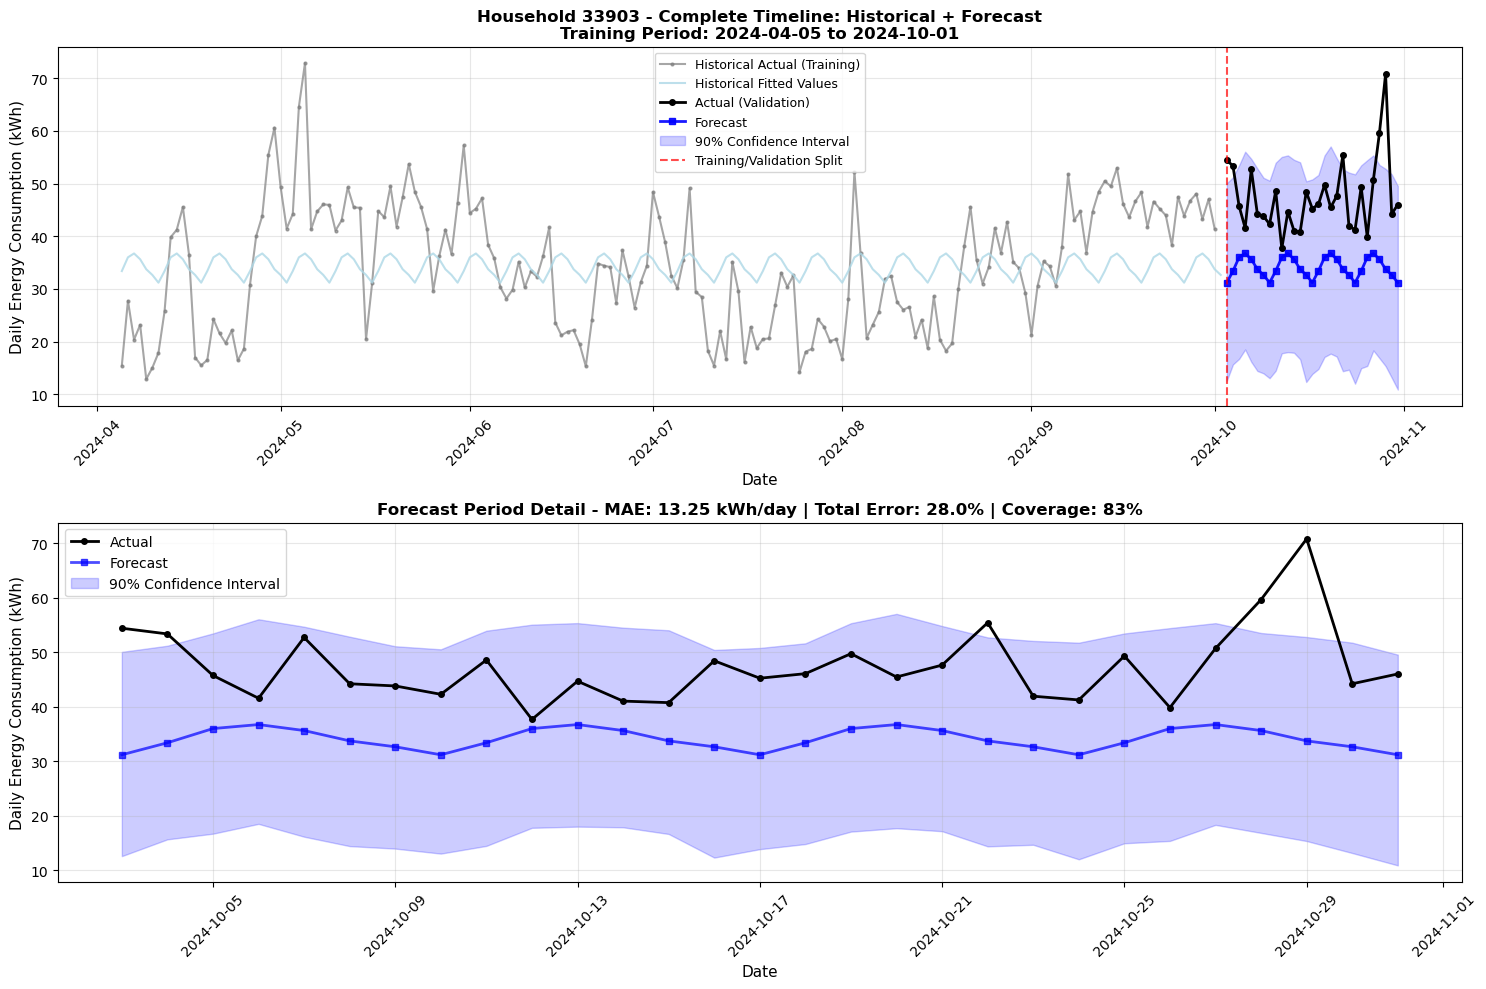

14:41:23 - cmdstanpy - INFO - Chain [1] start processing
14:41:23 - cmdstanpy - INFO - Chain [1] done processing


  Historical Analysis:
    Training period average: 34.2 kWh/day (±11.7)
    Validation period average (actual): 47.3 kWh/day
    Forecast average: 34.1 kWh/day
    Bias (forecast vs historical): -0.4%
    Validation vs historical change: +38.4%

Processing household: 94233
  MAE: 3.20 kWh/day
  MSE: 14.51 kWh²/day
  RMSE: 3.81 kWh/day
  Coverage Rate (90% interval): 27.6%
  Total Actual: 162.45 kWh
  Total Predicted: 70.31 kWh
  Total Error: 92.14 kWh (56.72%)


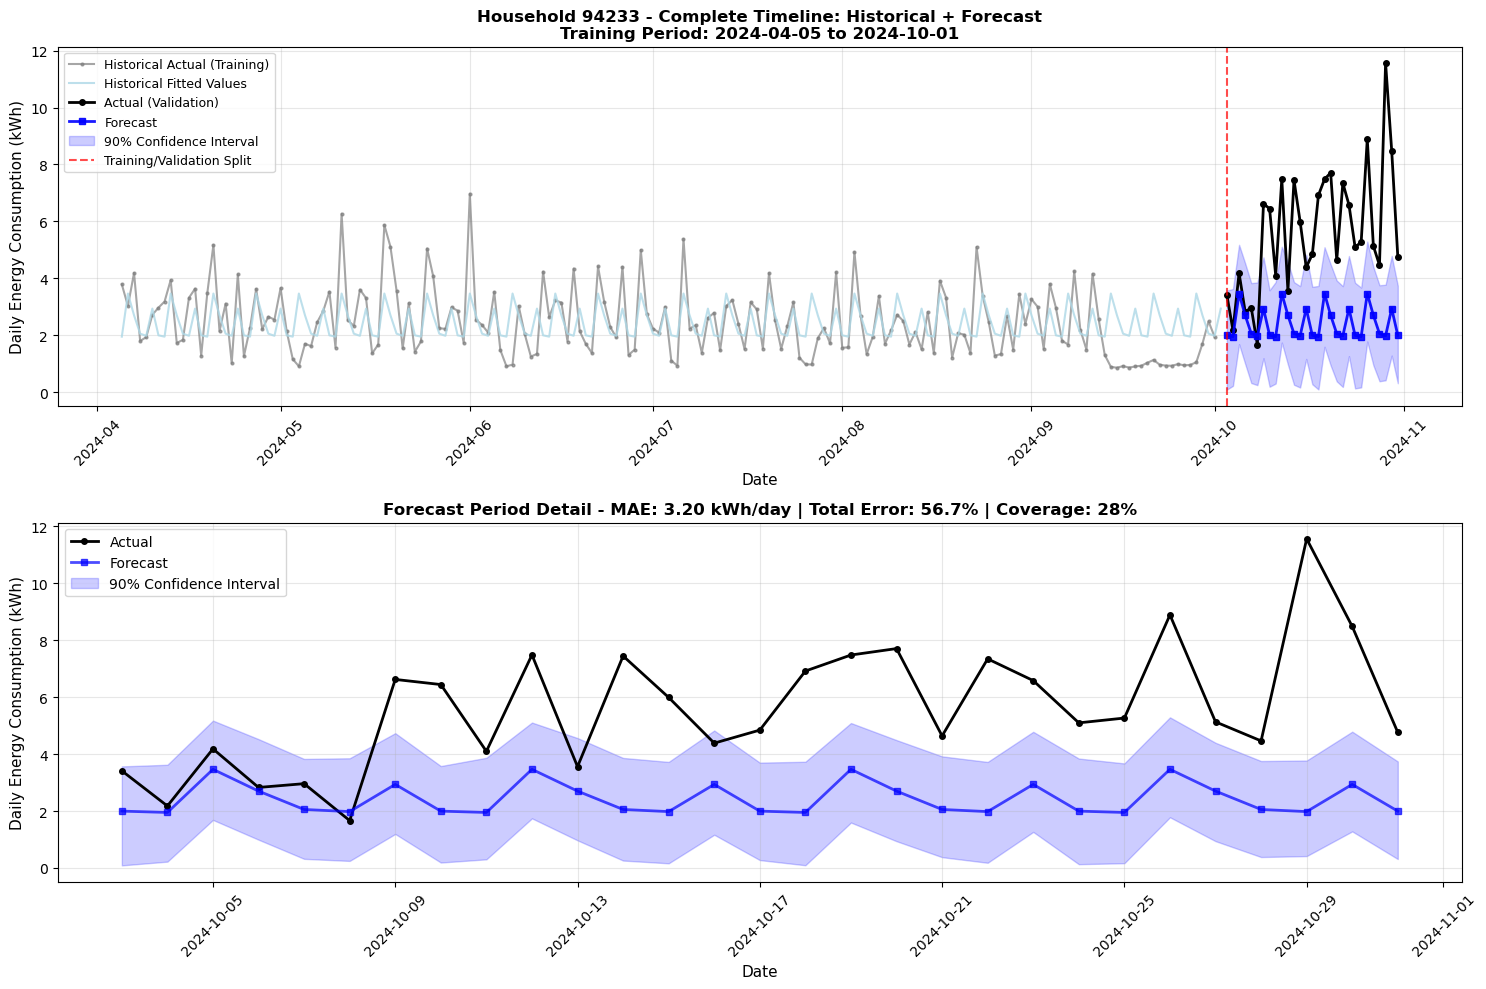

14:41:24 - cmdstanpy - INFO - Chain [1] start processing
14:41:24 - cmdstanpy - INFO - Chain [1] done processing


  Historical Analysis:
    Training period average: 2.4 kWh/day (±1.2)
    Validation period average (actual): 5.6 kWh/day
    Forecast average: 2.4 kWh/day
    Bias (forecast vs historical): -0.6%
    Validation vs historical change: +129.6%

Processing household: 53270
  MAE: 3.95 kWh/day
  MSE: 19.61 kWh²/day
  RMSE: 4.43 kWh/day
  Coverage Rate (90% interval): 100.0%
  Total Actual: 1287.47 kWh
  Total Predicted: 1401.97 kWh
  Total Error: -114.50 kWh (-8.89%)


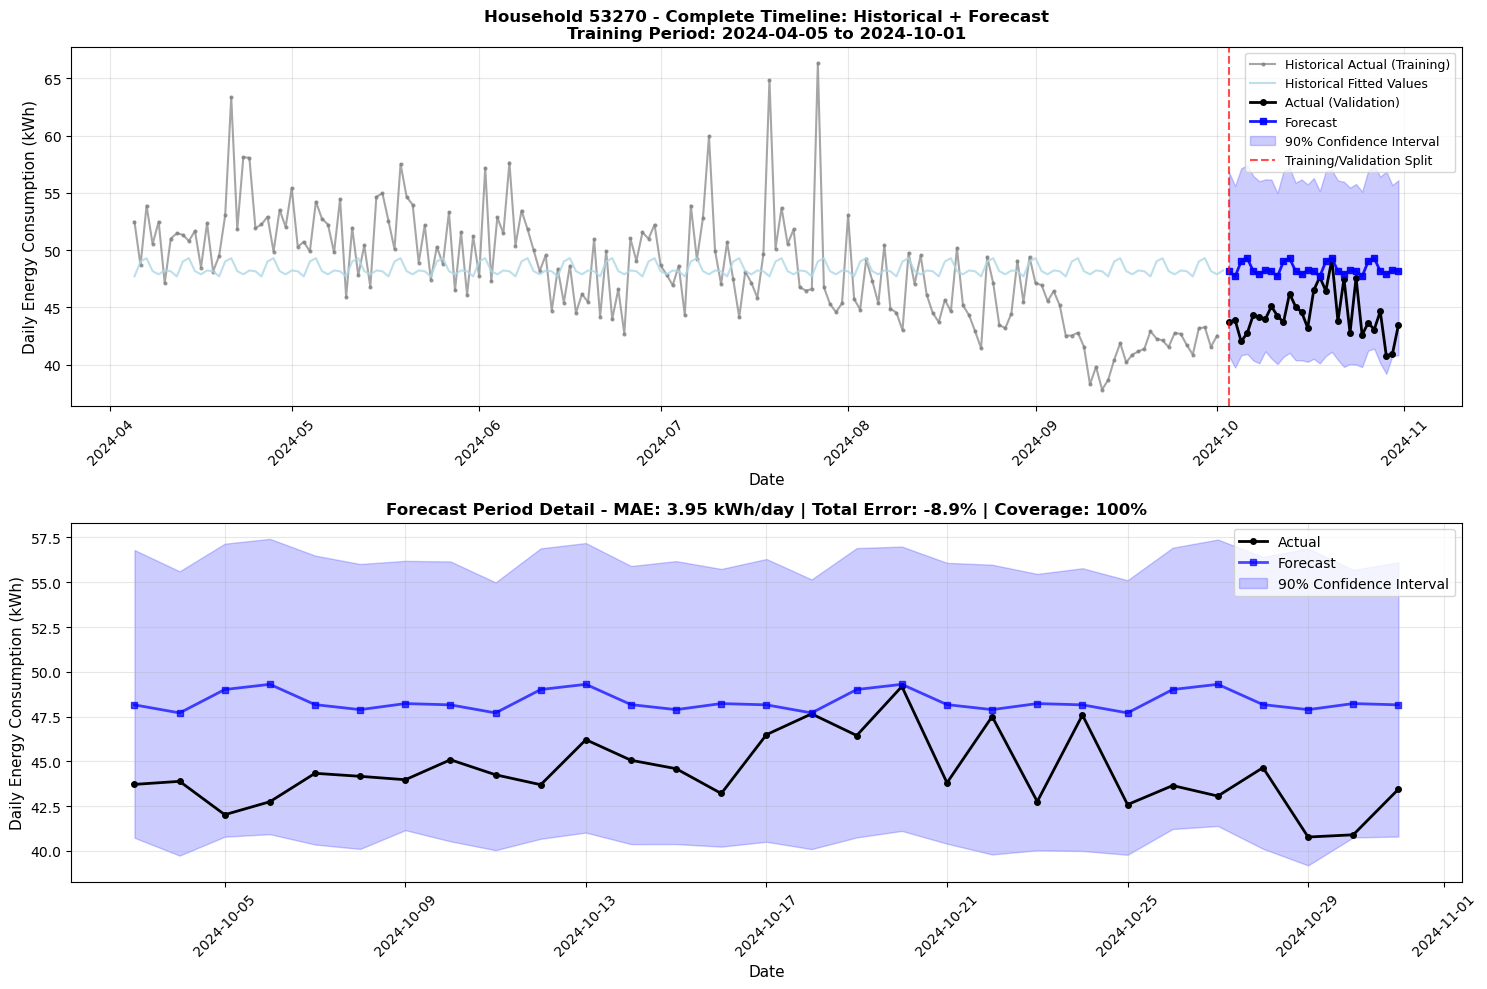

14:41:24 - cmdstanpy - INFO - Chain [1] start processing
14:41:24 - cmdstanpy - INFO - Chain [1] done processing


  Historical Analysis:
    Training period average: 48.4 kWh/day (±4.9)
    Validation period average (actual): 44.4 kWh/day
    Forecast average: 48.3 kWh/day
    Bias (forecast vs historical): -0.0%
    Validation vs historical change: -8.2%

Processing household: 38338
  MAE: 1.36 kWh/day
  MSE: 3.24 kWh²/day
  RMSE: 1.80 kWh/day
  Coverage Rate (90% interval): 96.6%
  Total Actual: 284.55 kWh
  Total Predicted: 258.57 kWh
  Total Error: 25.98 kWh (9.13%)


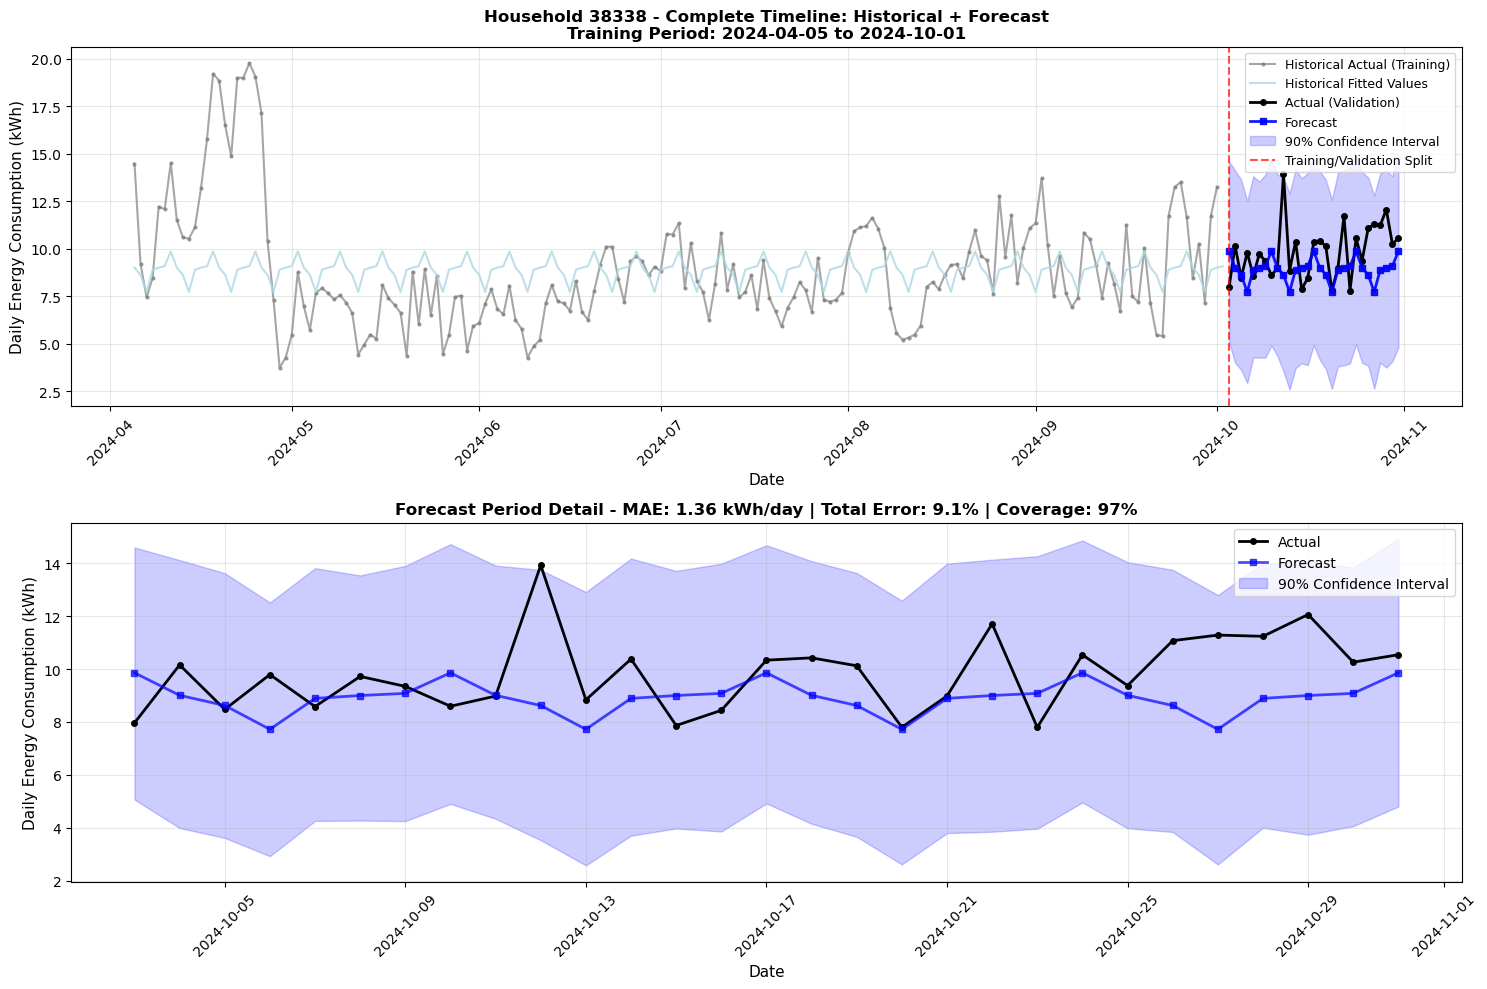

14:41:25 - cmdstanpy - INFO - Chain [1] start processing
14:41:25 - cmdstanpy - INFO - Chain [1] done processing


  Historical Analysis:
    Training period average: 8.9 kWh/day (±3.1)
    Validation period average (actual): 9.8 kWh/day
    Forecast average: 8.9 kWh/day
    Bias (forecast vs historical): +0.5%
    Validation vs historical change: +10.5%

Processing household: 17779
  MAE: 7.69 kWh/day
  MSE: 105.65 kWh²/day
  RMSE: 10.28 kWh/day
  Coverage Rate (90% interval): 96.6%
  Total Actual: 913.68 kWh
  Total Predicted: 1020.19 kWh
  Total Error: -106.51 kWh (-11.66%)


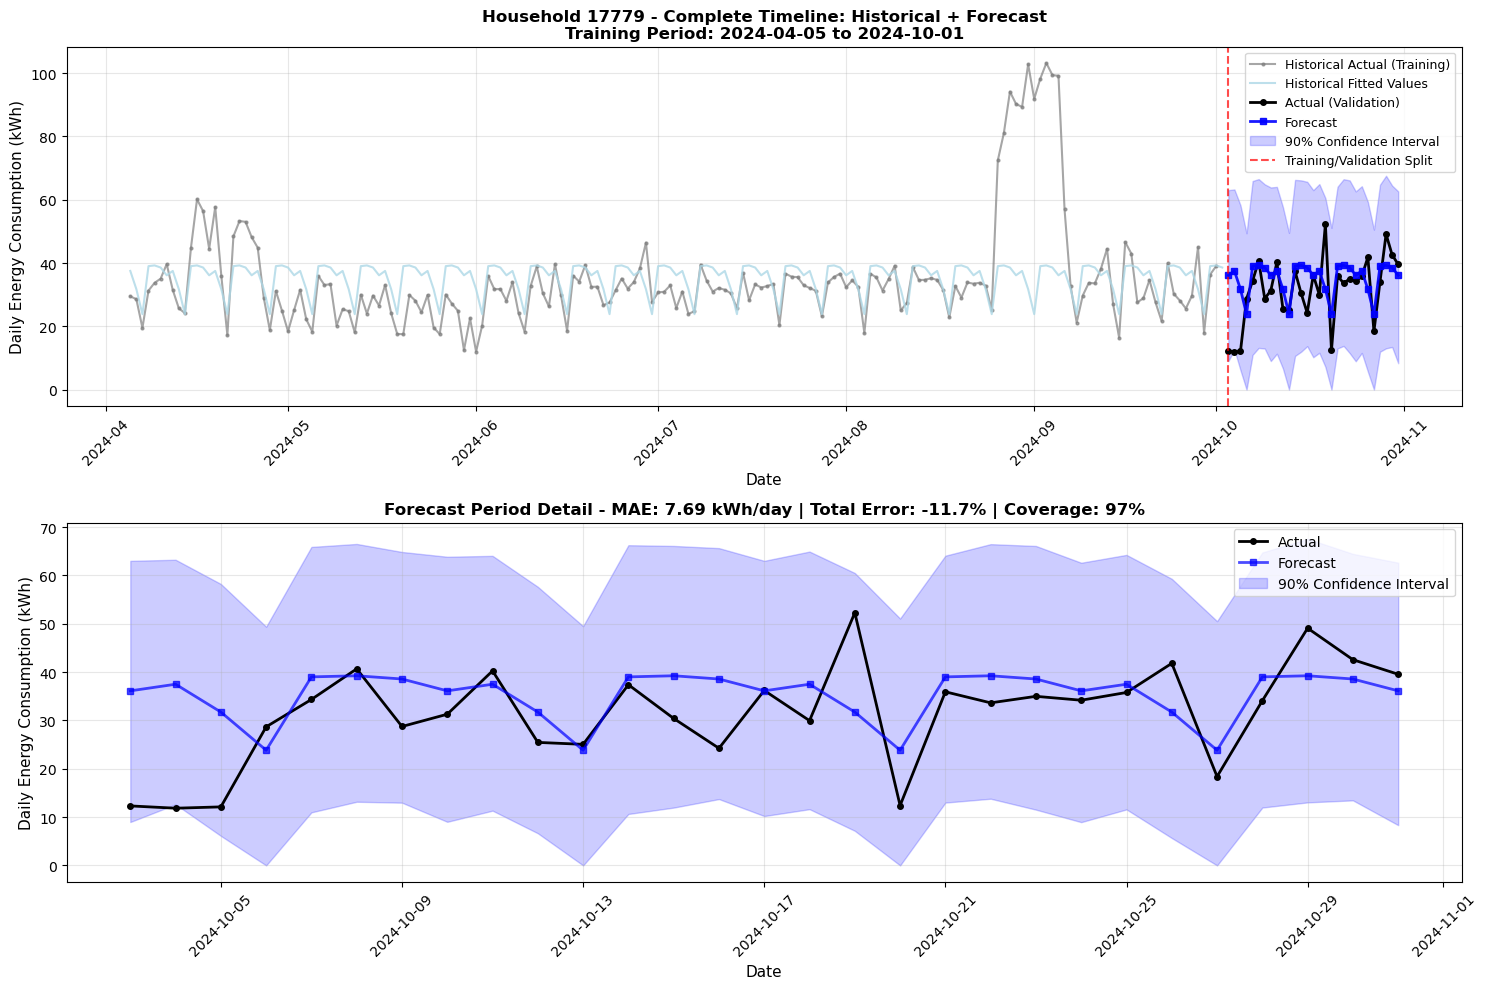

14:41:25 - cmdstanpy - INFO - Chain [1] start processing
14:41:25 - cmdstanpy - INFO - Chain [1] done processing


  Historical Analysis:
    Training period average: 35.1 kWh/day (±17.1)
    Validation period average (actual): 31.5 kWh/day
    Forecast average: 35.2 kWh/day
    Bias (forecast vs historical): +0.2%
    Validation vs historical change: -10.3%

Processing household: 51834
  MAE: 16.95 kWh/day
  MSE: 365.43 kWh²/day
  RMSE: 19.12 kWh/day
  Coverage Rate (90% interval): 27.6%
  Total Actual: 811.76 kWh
  Total Predicted: 330.75 kWh
  Total Error: 481.01 kWh (59.25%)


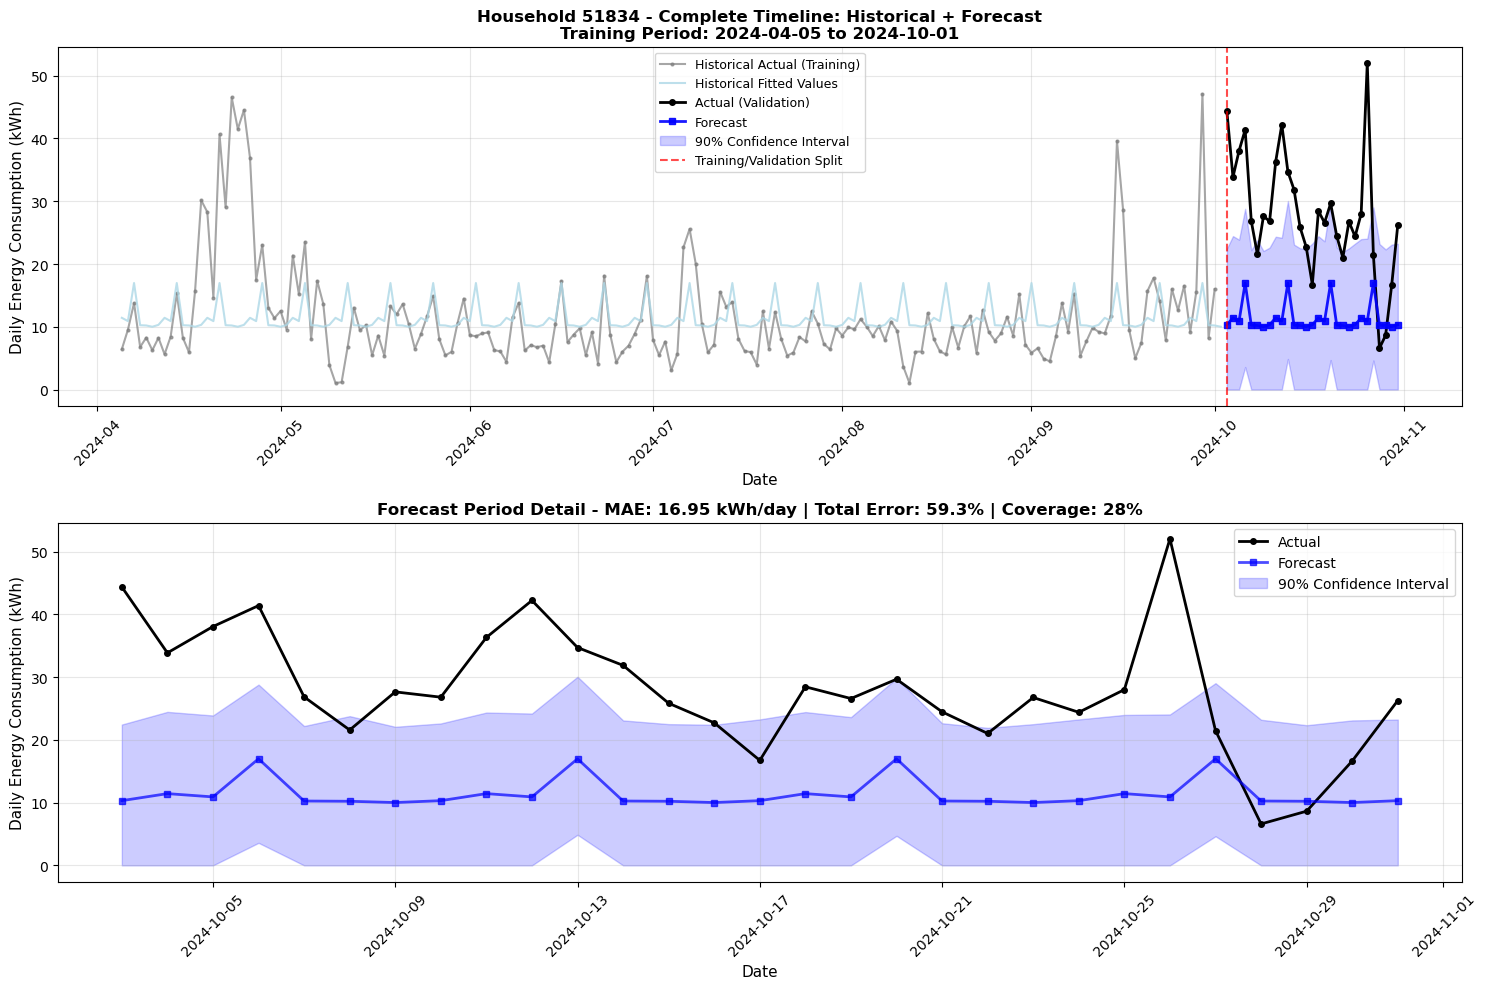

14:41:25 - cmdstanpy - INFO - Chain [1] start processing
14:41:25 - cmdstanpy - INFO - Chain [1] done processing


  Historical Analysis:
    Training period average: 11.5 kWh/day (±8.1)
    Validation period average (actual): 28.0 kWh/day
    Forecast average: 11.4 kWh/day
    Bias (forecast vs historical): -0.5%
    Validation vs historical change: +144.3%

Processing household: 55036
  MAE: 3.75 kWh/day
  MSE: 25.61 kWh²/day
  RMSE: 5.06 kWh/day
  Coverage Rate (90% interval): 93.1%
  Total Actual: 1153.40 kWh
  Total Predicted: 1115.05 kWh
  Total Error: 38.35 kWh (3.33%)


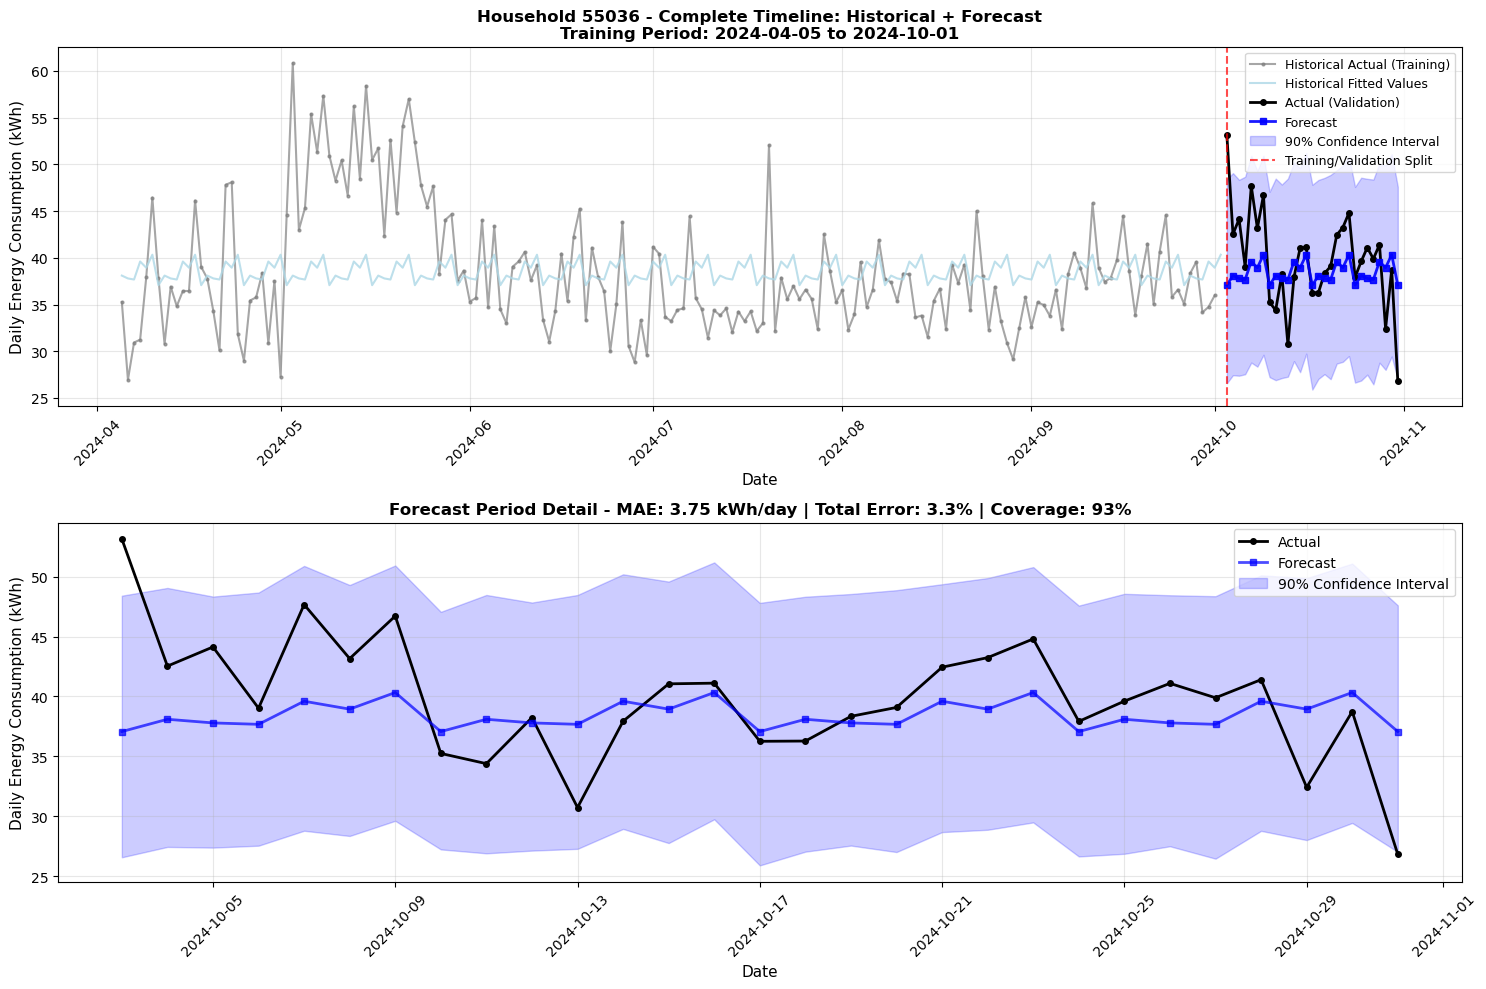

14:41:26 - cmdstanpy - INFO - Chain [1] start processing
14:41:26 - cmdstanpy - INFO - Chain [1] done processing


  Historical Analysis:
    Training period average: 38.5 kWh/day (±6.6)
    Validation period average (actual): 39.8 kWh/day
    Forecast average: 38.4 kWh/day
    Bias (forecast vs historical): -0.1%
    Validation vs historical change: +3.3%

Processing household: synthetic_household
  MAE: 1.25 kWh/day
  MSE: 1.64 kWh²/day
  RMSE: 1.28 kWh/day
  Coverage Rate (90% interval): 41.4%
  Total Actual: 212.40 kWh
  Total Predicted: 176.12 kWh
  Total Error: 36.28 kWh (17.08%)


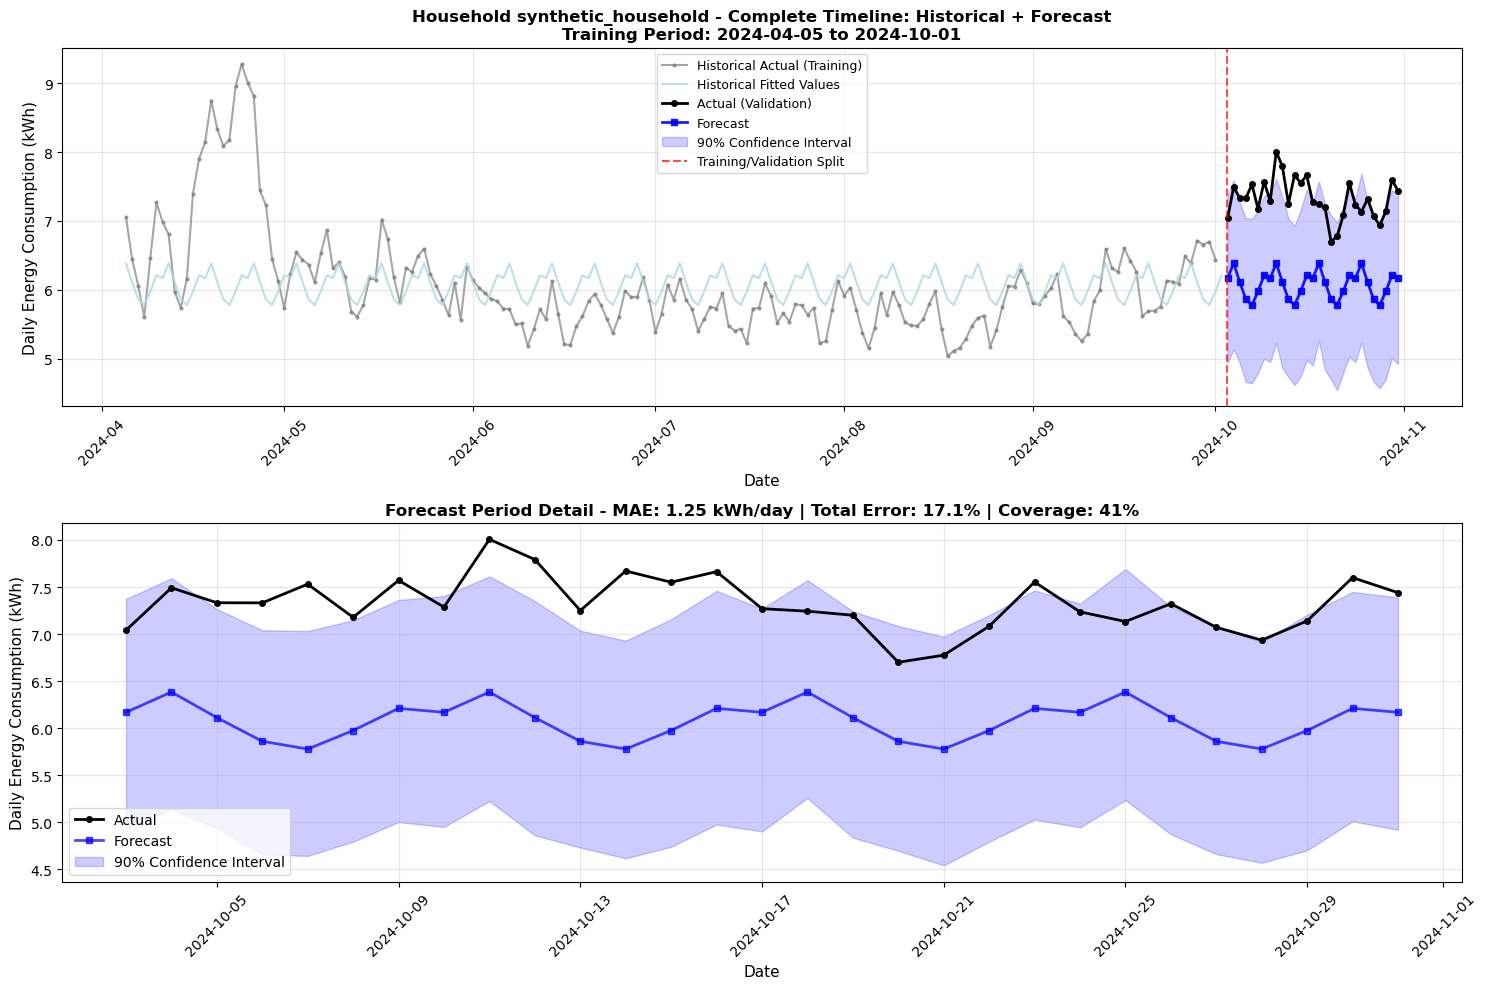

14:41:26 - cmdstanpy - INFO - Chain [1] start processing
14:41:26 - cmdstanpy - INFO - Chain [1] done processing


  Historical Analysis:
    Training period average: 6.1 kWh/day (±0.8)
    Validation period average (actual): 7.3 kWh/day
    Forecast average: 6.1 kWh/day
    Bias (forecast vs historical): +0.1%
    Validation vs historical change: +20.7%

Processing household: 35467
  MAE: 7.20 kWh/day
  MSE: 153.84 kWh²/day
  RMSE: 12.40 kWh/day
  Coverage Rate (90% interval): 96.6%
  Total Actual: 886.97 kWh
  Total Predicted: 950.39 kWh
  Total Error: -63.42 kWh (-7.15%)


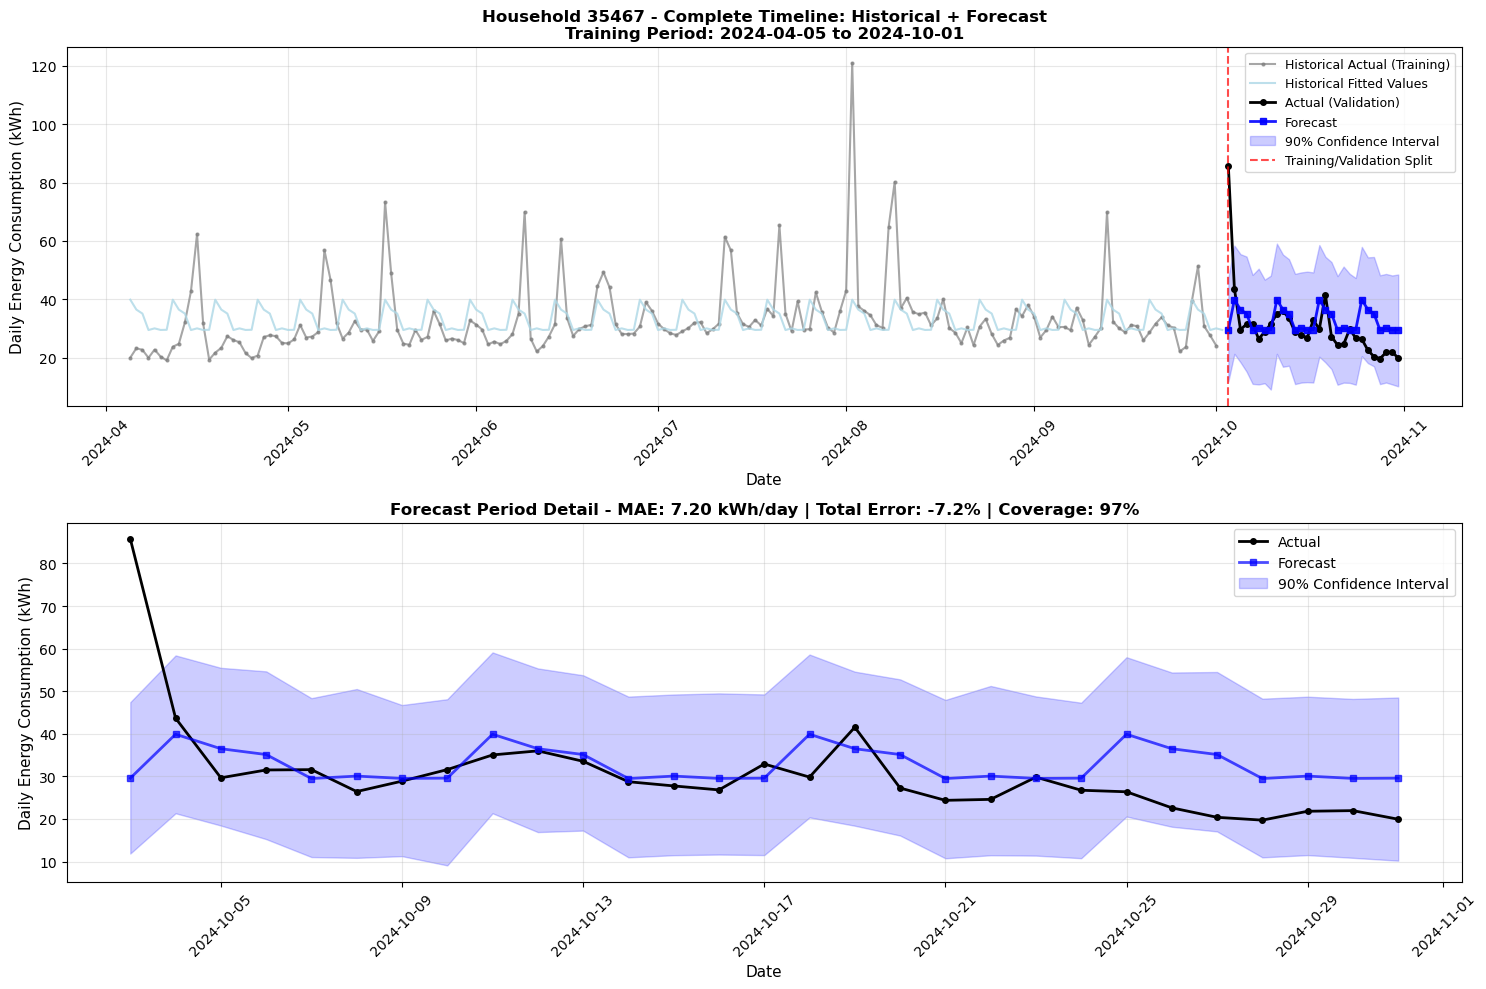

14:41:26 - cmdstanpy - INFO - Chain [1] start processing
14:41:26 - cmdstanpy - INFO - Chain [1] done processing


  Historical Analysis:
    Training period average: 32.9 kWh/day (±12.3)
    Validation period average (actual): 30.6 kWh/day
    Forecast average: 32.8 kWh/day
    Bias (forecast vs historical): -0.5%
    Validation vs historical change: -7.1%

Processing household: 66108
  MAE: 5.38 kWh/day
  MSE: 50.11 kWh²/day
  RMSE: 7.08 kWh/day
  Coverage Rate (90% interval): 93.1%
  Total Actual: 1584.19 kWh
  Total Predicted: 1471.37 kWh
  Total Error: 112.82 kWh (7.12%)


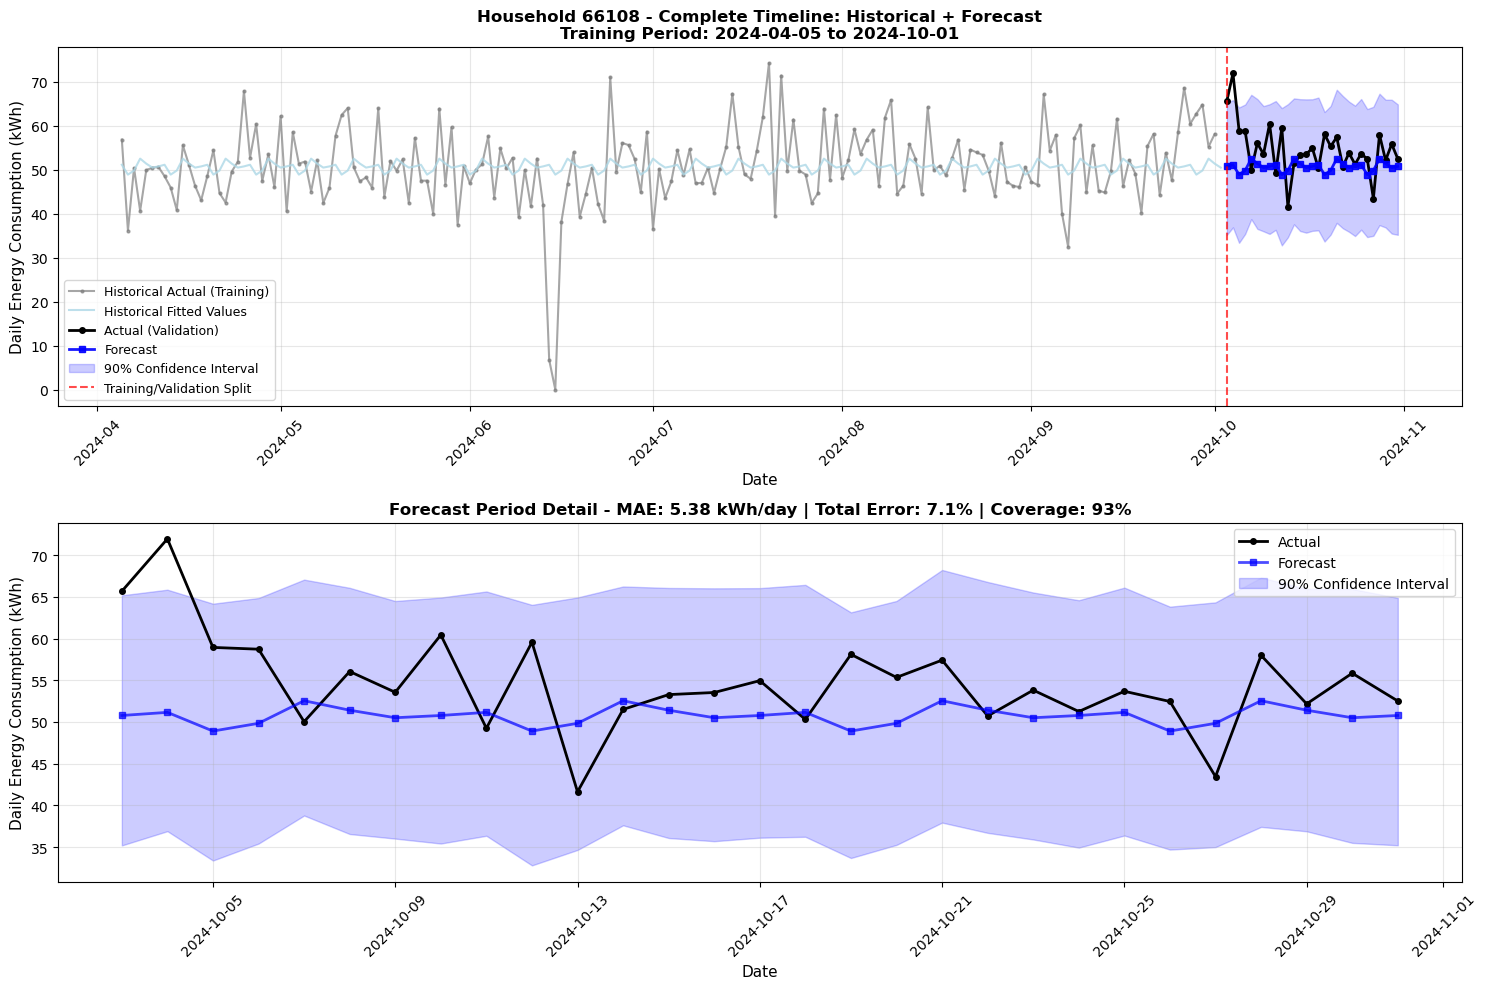

  Historical Analysis:
    Training period average: 50.7 kWh/day (±9.1)
    Validation period average (actual): 54.6 kWh/day
    Forecast average: 50.7 kWh/day
    Bias (forecast vs historical): +0.0%
    Validation vs historical change: +7.7%

SUMMARY STATISTICS - Daily Total Energy Forecasting

Number of households: 10

Average Metrics Across All Households:
  Mean MAE: 6.40 kWh/day (±5.13)
  Mean MSE: 96.48 kWh²/day (±120.07)
  Mean RMSE: 8.03 kWh/day (±5.97)
  Mean Coverage Rate: 75.5% (expected: 90%)
  Mean Total Error: 15.29% (±25.55%)

DETAILED RESULTS BY HOUSEHOLD


household_id    mae   rmse  coverage_rate  total_actual_kwh  \
7  synthetic_household   1.25   1.28          41.38            212.40   
3                38338   1.36   1.80          96.55            284.55   
1                94233   3.20   3.81          27.59            162.45   
6                55036   3.75   5.06          93.10           1153.40   
2                53270   3.95   4.43         100.00           1287.47   
9                66108   5.38   7.08          93.10           1584.19   
8                35467   7.20  12.40          96.55            886.97   
4                17779   7.69  10.28          96.55            913.68   
0                33903  13.25  15.00          82.76           1372.42   
5                51834  16.95  19.12          27.59            811.76   

   total_predicted_kwh  total_error_pct  
7               176.12            17.08  
3               258.57             9.13  
1                70.31            56.72  
6              1115.05             3.33  
2              1401.97            -8.89  
9              1471.37             7.12  
8               950.39            -7.15  
4              1020.19           -11.66  
0               988.18            28.00  
5               330.75            59.25

In [18]:
# Test the daily forecasting method on all selected households
results = []

print("Forecasting daily total energy for each household...")
print("=" * 80)

for household_id in train_data.keys():
    print(f"\nProcessing household: {household_id}")
    
    try:
        # Get training and validation data
        train = train_data[household_id]
        validation = validation_data[household_id]
        
        # Forecast daily totals for next 30 days
        forecast, model = forecast_daily_total_energy(train, forecast_days=validation_days)
        
        # Get only the forecasted period (future dates)
        forecast_start_date = train['datetime'].max() + pd.Timedelta(days=1)
        future_forecast = forecast[forecast['ds'] >= forecast_start_date].copy()
        
        # Aggregate validation data to daily totals for comparison
        validation_daily = validation.copy()
        validation_daily['datetime'] = pd.to_datetime(validation_daily['datetime'])
        validation_daily = validation_daily.set_index('datetime').resample('D')['value'].sum().reset_index()
        validation_daily.columns = ['ds', 'y']
        
        # Merge forecast with actual values
        comparison = pd.merge(
            validation_daily,
            future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
            on='ds',
            how='inner'
        )
        
        if len(comparison) == 0:
            print(f"  Warning: No overlapping dates for comparison")
            continue
        
        # Calculate metrics
        actual = comparison['y'].values
        predicted = comparison['yhat'].values
        
        # Absolute errors
        absolute_errors = np.abs(actual - predicted)
        
        # Mean Absolute Error (MAE)
        mae = mean_absolute_error(actual, predicted)
        
        # Mean Squared Error (MSE)
        mse = mean_squared_error(actual, predicted)
        
        # Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mse)
        
        # Coverage rate: % of actual values within 90% prediction interval
        lower_bounds = comparison['yhat_lower'].values
        upper_bounds = comparison['yhat_upper'].values
        within_interval = ((actual >= lower_bounds) & (actual <= upper_bounds)).sum()
        coverage_rate = (within_interval / len(actual)) * 100
        
        # Total energy comparison
        total_actual = actual.sum()
        total_predicted = predicted.sum()
        total_error = total_actual - total_predicted
        total_error_pct = (total_error / total_actual) * 100

        # Store results 
        results.append({
            'household_id': household_id,  # You likely need this too
            'mae': mae,
            'mse': mse,
            'rmse': rmse,
            'coverage_rate': coverage_rate,
            'total_actual_kwh': total_actual,
            'total_predicted_kwh': total_predicted,
            'total_error_kwh': total_error,
            'total_error_pct': total_error_pct,
            'n_days': len(comparison),
            'mean_daily_consumption': actual.mean(),
            'std_daily_consumption': actual.std()
        })
        
        print(f"  MAE: {mae:.2f} kWh/day")
        print(f"  MSE: {mse:.2f} kWh²/day")
        print(f"  RMSE: {rmse:.2f} kWh/day")
        print(f"  Coverage Rate (90% interval): {coverage_rate:.1f}%")
        print(f"  Total Actual: {total_actual:.2f} kWh")
        print(f"  Total Predicted: {total_predicted:.2f} kWh")
        print(f"  Total Error: {total_error:.2f} kWh ({total_error_pct:.2f}%)")
        
        # Enhanced visualization with historical data
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
        
        # Prepare historical daily data from training set
        train_daily = train.copy()
        train_daily['datetime'] = pd.to_datetime(train_daily['datetime'])
        train_daily = train_daily.set_index('datetime').resample('D')['value'].sum().reset_index()
        train_daily.columns = ['ds', 'y']
        
        # Get the historical forecast (fitted values) from the full forecast
        historical_forecast = forecast[forecast['ds'] < forecast_start_date].copy()
        
        # Plot 1: Full timeline with historical data, forecast, and actual
        # Historical actual data (training period)
        ax1.plot(train_daily['ds'], train_daily['y'], 'o-', color='gray', 
                label='Historical Actual (Training)', linewidth=1.5, markersize=2, alpha=0.7)
        
        # Historical fitted values (to see how well model fits training data)
        ax1.plot(historical_forecast['ds'], historical_forecast['yhat'], '-', color='lightblue', 
                label='Historical Fitted Values', linewidth=1.5, alpha=0.8)
        
        # Validation actual values
        ax1.plot(comparison['ds'], comparison['y'], 'o-', color='black', 
                label='Actual (Validation)', linewidth=2, markersize=4)
        
        # Forecast values
        ax1.plot(comparison['ds'], comparison['yhat'], 's-', color='blue', 
                label='Forecast', linewidth=2, markersize=4, alpha=0.9)
        
        # Forecast confidence interval
        ax1.fill_between(comparison['ds'], 
                        comparison['yhat_lower'], 
                        comparison['yhat_upper'],
                        alpha=0.2, color='blue', label='90% Confidence Interval')
        
        # Add vertical line to separate training and validation periods
        ax1.axvline(x=forecast_start_date, color='red', linestyle='--', alpha=0.7, 
                   label='Training/Validation Split')
        
        ax1.set_xlabel('Date', fontsize=11)
        ax1.set_ylabel('Daily Energy Consumption (kWh)', fontsize=11)
        ax1.set_title(f'Household {household_id} - Complete Timeline: Historical + Forecast\n'
                     f'Training Period: {train_daily["ds"].min().strftime("%Y-%m-%d")} to {train_daily["ds"].max().strftime("%Y-%m-%d")}',
                     fontsize=12, fontweight='bold')
        ax1.legend(loc='best', fontsize=9)
        ax1.grid(True, alpha=0.3)
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
        
        # Plot 2: Zoomed view of forecast period only (same as before but cleaner)
        ax2.plot(comparison['ds'], comparison['y'], 'o-', color='black', 
                label='Actual', linewidth=2, markersize=4)
        
        ax2.plot(comparison['ds'], comparison['yhat'], 's-', color='blue', 
                label='Forecast', linewidth=2, markersize=4, alpha=0.7)
        
        ax2.fill_between(comparison['ds'], 
                        comparison['yhat_lower'], 
                        comparison['yhat_upper'],
                        alpha=0.2, color='blue', label='90% Confidence Interval')
        
        ax2.set_xlabel('Date', fontsize=11)
        ax2.set_ylabel('Daily Energy Consumption (kWh)', fontsize=11)
        ax2.set_title(f'Forecast Period Detail - MAE: {mae:.2f} kWh/day | Total Error: {total_error_pct:.1f}% | Coverage: {coverage_rate:.0f}%',
                     fontsize=12, fontweight='bold')
        ax2.legend(loc='best', fontsize=10)
        ax2.grid(True, alpha=0.3)
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Additional analysis: Print some insights about historical vs forecast patterns
        historical_mean = train_daily['y'].mean()
        historical_std = train_daily['y'].std()
        forecast_mean = comparison['yhat'].mean()
        actual_validation_mean = comparison['y'].mean()
        
        print(f"  Historical Analysis:")
        print(f"    Training period average: {historical_mean:.1f} kWh/day (±{historical_std:.1f})")
        print(f"    Validation period average (actual): {actual_validation_mean:.1f} kWh/day")
        print(f"    Forecast average: {forecast_mean:.1f} kWh/day")
        print(f"    Bias (forecast vs historical): {((forecast_mean - historical_mean) / historical_mean * 100):+.1f}%")
        print(f"    Validation vs historical change: {((actual_validation_mean - historical_mean) / historical_mean * 100):+.1f}%")
        
    except Exception as e:
        print(f"  Error processing household {household_id}: {str(e)}")
        continue

# Create results DataFrame
results_df = pd.DataFrame(results)

print("\n" + "=" * 80)
print("SUMMARY STATISTICS - Daily Total Energy Forecasting")
print("=" * 80)
print(f"\nNumber of households: {len(results_df)}")
print(f"\nAverage Metrics Across All Households:")
print(f"  Mean MAE: {results_df['mae'].mean():.2f} kWh/day (±{results_df['mae'].std():.2f})")
print(f"  Mean MSE: {results_df['mse'].mean():.2f} kWh²/day (±{results_df['mse'].std():.2f})")
print(f"  Mean RMSE: {results_df['rmse'].mean():.2f} kWh/day (±{results_df['rmse'].std():.2f})")
print(f"  Mean Coverage Rate: {results_df['coverage_rate'].mean():.1f}% (expected: 90%)")
print(f"  Mean Total Error: {results_df['total_error_pct'].mean():.2f}% (±{results_df['total_error_pct'].std():.2f}%)")

# Display full results table
print("\n" + "=" * 80)
print("DETAILED RESULTS BY HOUSEHOLD")
print("=" * 80)
display(results_df.sort_values('mae')[['household_id', 'mae', 'rmse', 'coverage_rate',
                                         'total_actual_kwh', 'total_predicted_kwh', 
                                         'total_error_pct']].round(2))


# Create daily usage profile for individual user for weekdays and weekends/holidays

Creating detailed usage profiles for selected households...

Creating profile for household: 33903
  Peak usage: Weekdays 09:00 (3.14 kWh)
              Weekends 09:00 (3.04 kWh)
  Daily avg:  Weekdays 23.7 kWh, Weekends 10.7 kWh


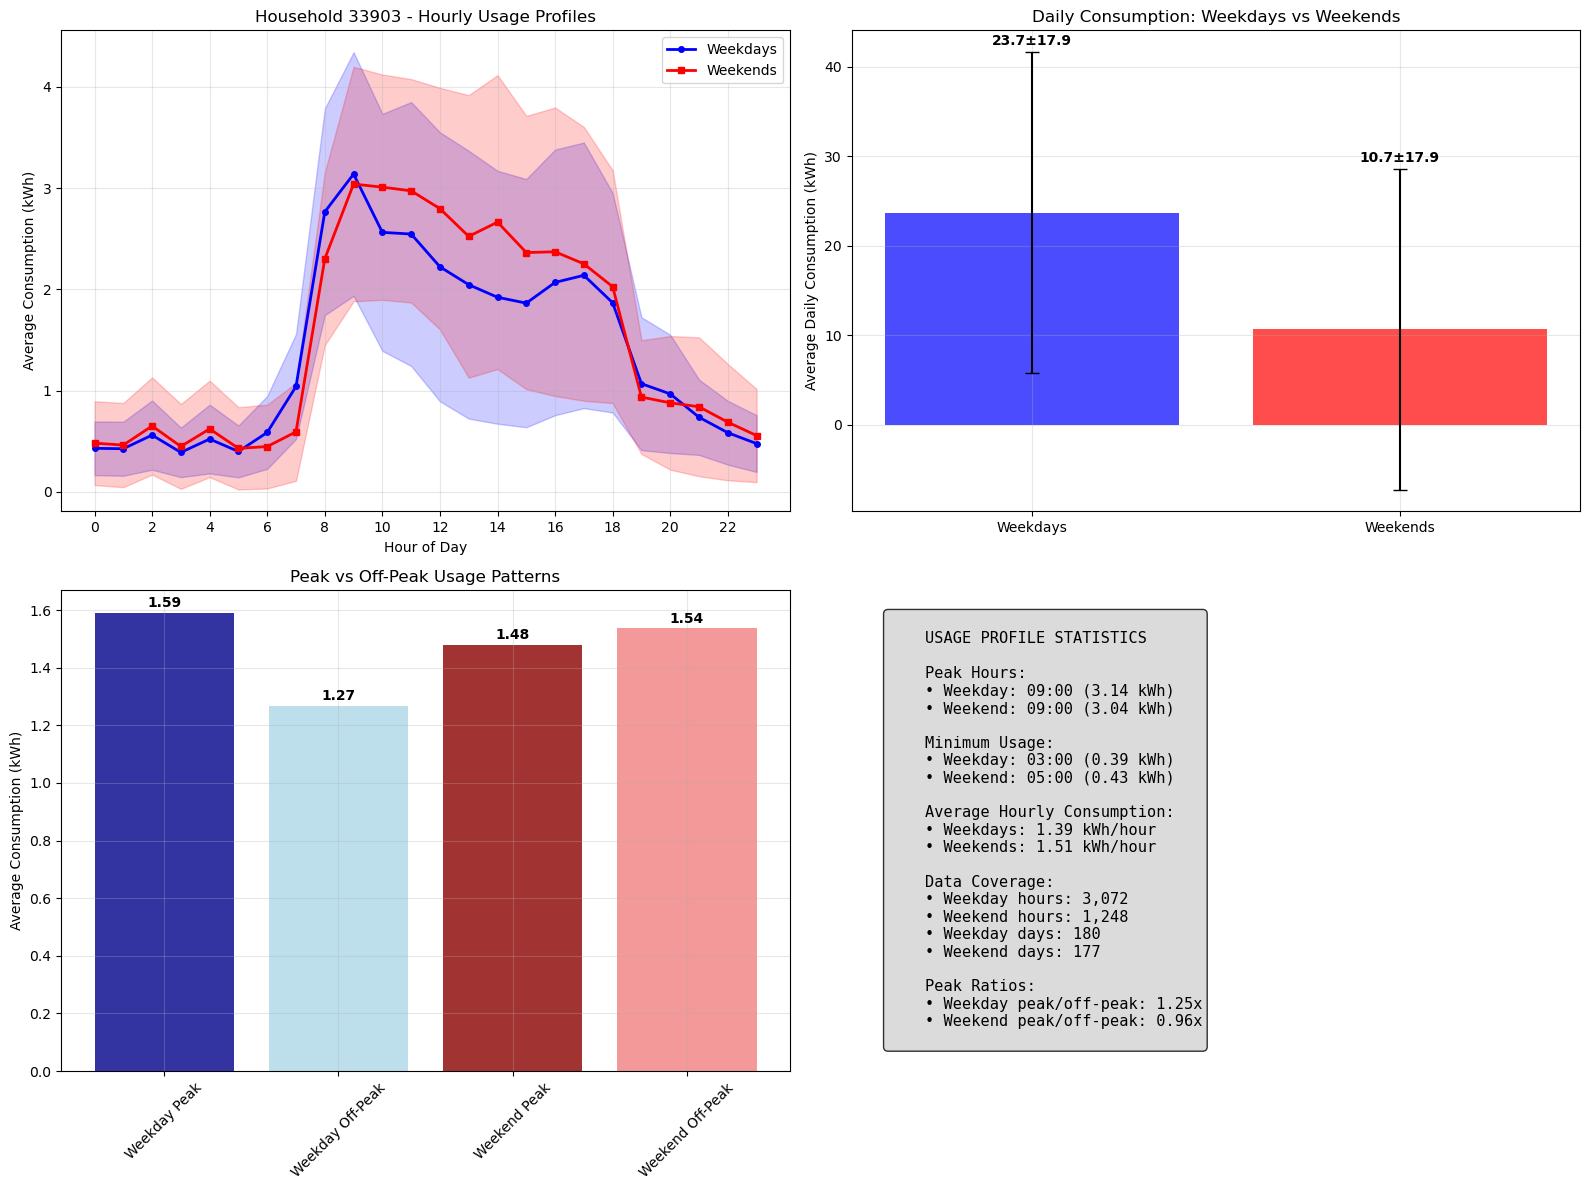


Creating profile for household: 94233
  Peak usage: Weekdays 18:00 (0.24 kWh)
              Weekends 10:00 (0.36 kWh)
  Daily avg:  Weekdays 1.5 kWh, Weekends 0.9 kWh


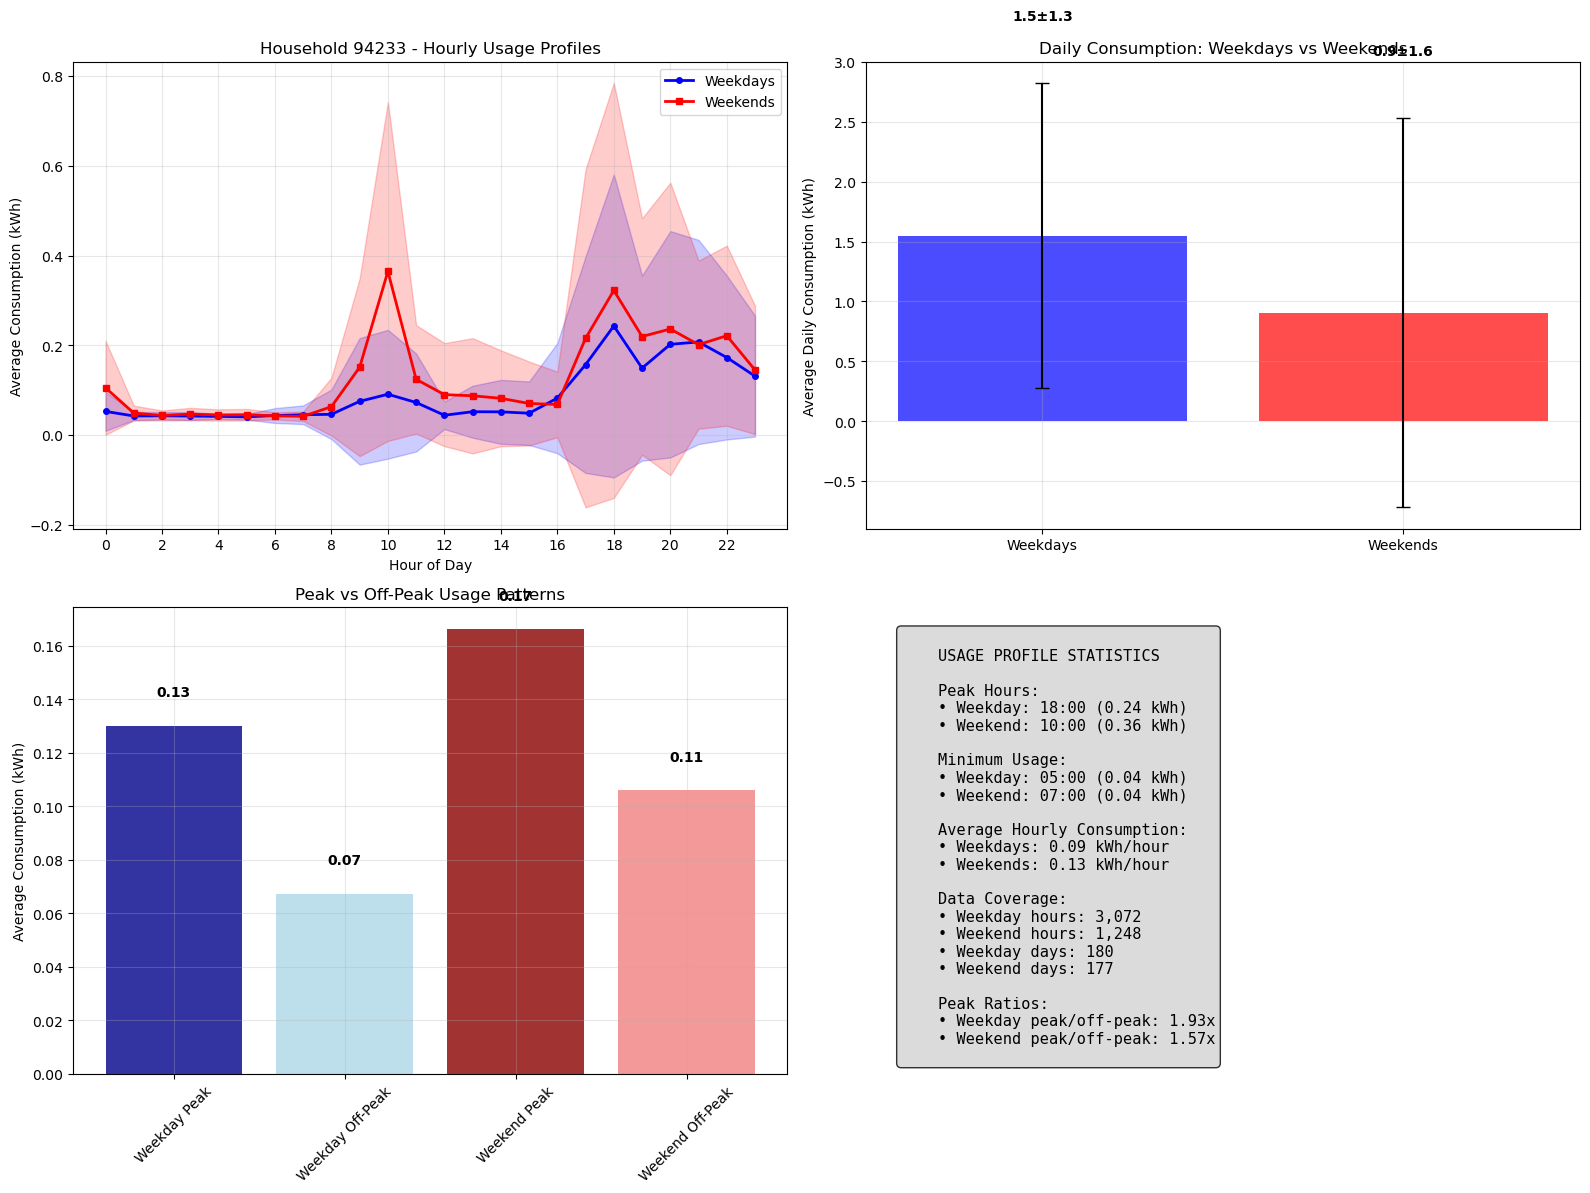


Creating profile for household: 53270
  Peak usage: Weekdays 21:00 (7.07 kWh)
              Weekends 21:00 (7.24 kWh)
  Daily avg:  Weekdays 34.2 kWh, Weekends 14.4 kWh


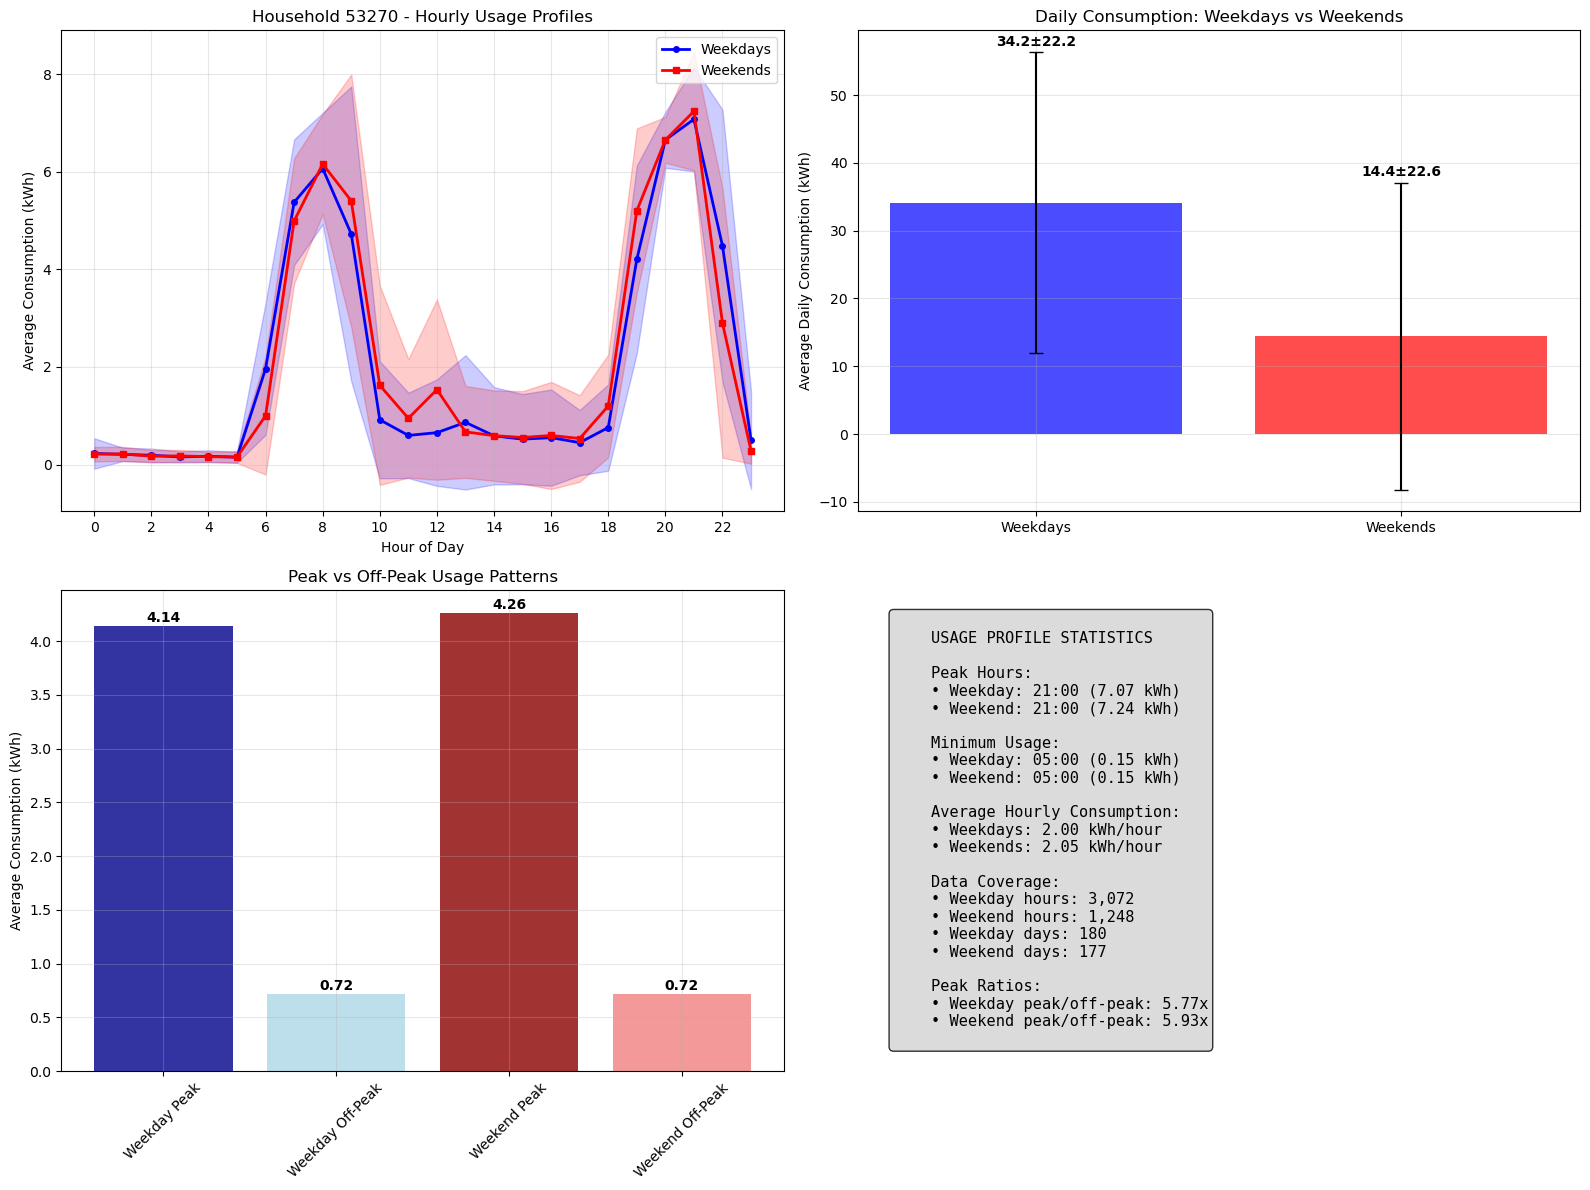


Created 3 user profiles successfully.


In [19]:
def create_user_profile(household_id, train_df):
    """
    Create detailed usage profiles for individual users for weekdays and weekends.
    
    Args:
        household_id: ID of the household
        train_df: DataFrame with 'datetime' and 'value' columns (hourly data)

    Returns:
        Dictionary containing:
        - 'weekday_profile': Average hourly usage for weekdays (Mon-Fri)
        - 'weekend_profile': Average hourly usage for weekends (Sat-Sun)
        - 'daily_totals': Average daily consumption for weekdays vs weekends
        - 'profile_stats': Statistical summary of usage patterns
    """
    # Create a copy to avoid modifying original data
    df = train_df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.set_index('datetime')
    
    # Add time-based features
    df['hour'] = df.index.hour
    df['weekday'] = df.index.dayofweek  # 0=Monday, 6=Sunday
    df['is_weekend'] = df['weekday'].isin([5, 6])  # Saturday=5, Sunday=6
    
    # Separate weekday and weekend data
    weekday_data = df[df['is_weekend'] == False].copy()
    weekend_data = df[df['is_weekend'] == True].copy()
    
    # Create hourly profiles (average usage by hour of day)
    weekday_profile = weekday_data.groupby('hour')['value'].agg(['mean', 'std', 'count']).reset_index()
    weekday_profile.columns = ['hour', 'avg_consumption', 'std_consumption', 'data_points']
    weekday_profile['profile_type'] = 'weekday'
    
    weekend_profile = weekend_data.groupby('hour')['value'].agg(['mean', 'std', 'count']).reset_index()
    weekend_profile.columns = ['hour', 'avg_consumption', 'std_consumption', 'data_points']
    weekend_profile['profile_type'] = 'weekend'
    
    # Calculate daily totals for comparison
    weekday_daily_totals = weekday_data.resample('D')['value'].sum()
    weekend_daily_totals = weekend_data.resample('D')['value'].sum()
    
    daily_totals = {
        'weekday_avg': weekday_daily_totals.mean(),
        'weekday_std': weekday_daily_totals.std(),
        'weekend_avg': weekend_daily_totals.mean(),
        'weekend_std': weekend_daily_totals.std(),
        'weekday_days': len(weekday_daily_totals),
        'weekend_days': len(weekend_daily_totals)
    }
    
    # Calculate additional statistics
    profile_stats = {
        'peak_hour_weekday': weekday_profile.loc[weekday_profile['avg_consumption'].idxmax(), 'hour'],
        'peak_consumption_weekday': weekday_profile['avg_consumption'].max(),
        'peak_hour_weekend': weekend_profile.loc[weekend_profile['avg_consumption'].idxmax(), 'hour'],
        'peak_consumption_weekend': weekend_profile['avg_consumption'].max(),
        'min_hour_weekday': weekday_profile.loc[weekday_profile['avg_consumption'].idxmin(), 'hour'],
        'min_consumption_weekday': weekday_profile['avg_consumption'].min(),
        'min_hour_weekend': weekend_profile.loc[weekend_profile['avg_consumption'].idxmin(), 'hour'],
        'min_consumption_weekend': weekend_profile['avg_consumption'].min(),
        'total_hours_weekday': weekday_profile['data_points'].sum(),
        'total_hours_weekend': weekend_profile['data_points'].sum(),
        'avg_hourly_weekday': weekday_profile['avg_consumption'].mean(),
        'avg_hourly_weekend': weekend_profile['avg_consumption'].mean()
    }
    
    return {
        'household_id': household_id,
        'weekday_profile': weekday_profile,
        'weekend_profile': weekend_profile,
        'daily_totals': daily_totals,
        'profile_stats': profile_stats
    }

def visualize_user_profile(profile_data):
    """
    Visualize the user profile with comprehensive charts.
    
    Args:
        profile_data: Dictionary returned by create_user_profile()
    """
    household_id = profile_data['household_id']
    weekday_profile = profile_data['weekday_profile']
    weekend_profile = profile_data['weekend_profile']
    daily_totals = profile_data['daily_totals']
    stats = profile_data['profile_stats']
    
    # Create comprehensive visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Hourly consumption profiles
    ax1.plot(weekday_profile['hour'], weekday_profile['avg_consumption'], 
             'o-', color='blue', linewidth=2, markersize=4, label='Weekdays')
    ax1.fill_between(weekday_profile['hour'], 
                     weekday_profile['avg_consumption'] - weekday_profile['std_consumption'],
                     weekday_profile['avg_consumption'] + weekday_profile['std_consumption'],
                     alpha=0.2, color='blue')
    
    ax1.plot(weekend_profile['hour'], weekend_profile['avg_consumption'], 
             's-', color='red', linewidth=2, markersize=4, label='Weekends')
    ax1.fill_between(weekend_profile['hour'], 
                     weekend_profile['avg_consumption'] - weekend_profile['std_consumption'],
                     weekend_profile['avg_consumption'] + weekend_profile['std_consumption'],
                     alpha=0.2, color='red')
    
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Average Consumption (kWh)')
    ax1.set_title(f'Household {household_id} - Hourly Usage Profiles')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(range(0, 24, 2))
    
    # 2. Daily consumption comparison
    categories = ['Weekdays', 'Weekends']
    daily_means = [daily_totals['weekday_avg'], daily_totals['weekend_avg']]
    daily_stds = [daily_totals['weekday_std'], daily_totals['weekend_std']]
    
    bars = ax2.bar(categories, daily_means, yerr=daily_stds, 
                   color=['blue', 'red'], alpha=0.7, capsize=5)
    ax2.set_ylabel('Average Daily Consumption (kWh)')
    ax2.set_title(f'Daily Consumption: Weekdays vs Weekends')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, mean, std in zip(bars, daily_means, daily_stds):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + std + 0.5,
                f'{mean:.1f}±{std:.1f}', ha='center', va='bottom', fontweight='bold')
    
    # 3. Peak vs Off-peak analysis
    # Define peak hours (typically 6-9 AM and 5-9 PM)
    peak_hours = list(range(6, 10)) + list(range(17, 22))
    off_peak_hours = [h for h in range(24) if h not in peak_hours]
    
    weekday_peak = weekday_profile[weekday_profile['hour'].isin(peak_hours)]['avg_consumption'].mean()
    weekday_off_peak = weekday_profile[weekday_profile['hour'].isin(off_peak_hours)]['avg_consumption'].mean()
    weekend_peak = weekend_profile[weekend_profile['hour'].isin(peak_hours)]['avg_consumption'].mean()
    weekend_off_peak = weekend_profile[weekend_profile['hour'].isin(off_peak_hours)]['avg_consumption'].mean()
    
    peak_data = {
        'Weekday Peak': weekday_peak,
        'Weekday Off-Peak': weekday_off_peak,
        'Weekend Peak': weekend_peak,
        'Weekend Off-Peak': weekend_off_peak
    }
    
    colors = ['darkblue', 'lightblue', 'darkred', 'lightcoral']
    bars3 = ax3.bar(peak_data.keys(), peak_data.values(), color=colors, alpha=0.8)
    ax3.set_ylabel('Average Consumption (kWh)')
    ax3.set_title('Peak vs Off-Peak Usage Patterns')
    ax3.grid(True, alpha=0.3)
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
    
    # Add value labels
    for bar, value in zip(bars3, peak_data.values()):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # 4. Statistical summary
    ax4.axis('off')
    stats_text = f"""
    USAGE PROFILE STATISTICS
    
    Peak Hours:
    • Weekday: {stats['peak_hour_weekday']:02d}:00 ({stats['peak_consumption_weekday']:.2f} kWh)
    • Weekend: {stats['peak_hour_weekend']:02d}:00 ({stats['peak_consumption_weekend']:.2f} kWh)
    
    Minimum Usage:
    • Weekday: {stats['min_hour_weekday']:02d}:00 ({stats['min_consumption_weekday']:.2f} kWh)
    • Weekend: {stats['min_hour_weekend']:02d}:00 ({stats['min_consumption_weekend']:.2f} kWh)
    
    Average Hourly Consumption:
    • Weekdays: {stats['avg_hourly_weekday']:.2f} kWh/hour
    • Weekends: {stats['avg_hourly_weekend']:.2f} kWh/hour
    
    Data Coverage:
    • Weekday hours: {stats['total_hours_weekday']:,}
    • Weekend hours: {stats['total_hours_weekend']:,}
    • Weekday days: {daily_totals['weekday_days']}
    • Weekend days: {daily_totals['weekend_days']}
    
    Peak Ratios:
    • Weekday peak/off-peak: {weekday_peak/weekday_off_peak:.2f}x
    • Weekend peak/off-peak: {weekend_peak/weekend_off_peak:.2f}x
    """
    
    ax4.text(0.05, 0.95, stats_text, transform=ax4.transAxes, fontsize=11,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return profile_data

# Test the profile creation on a few households
print("Creating detailed usage profiles for selected households...")
print("=" * 80)

user_profiles = {}

for household_id in list(selected_ids)[:3]:  # Test on first 3 households
    print(f"\nCreating profile for household: {household_id}")
    
    try:
        # Create the profile
        profile = create_user_profile(household_id, train_data[household_id])
        user_profiles[household_id] = profile
        
        # Display basic statistics
        stats = profile['profile_stats']
        daily = profile['daily_totals']
        
        print(f"  Peak usage: Weekdays {stats['peak_hour_weekday']:02d}:00 ({stats['peak_consumption_weekday']:.2f} kWh)")
        print(f"              Weekends {stats['peak_hour_weekend']:02d}:00 ({stats['peak_consumption_weekend']:.2f} kWh)")
        print(f"  Daily avg:  Weekdays {daily['weekday_avg']:.1f} kWh, Weekends {daily['weekend_avg']:.1f} kWh")
        
        # Visualize the profile
        visualize_user_profile(profile)
        
    except Exception as e:
        print(f"  Error creating profile for {household_id}: {str(e)}")
        import traceback
        traceback.print_exc()

print(f"\nCreated {len(user_profiles)} user profiles successfully.")

## Enhanced Forecasting with Temperature Regressor

In [13]:
# Load temperature data
def load_temperature_data():
    """Load and prepare temperature data for use as a regressor."""
    # Try the combined data first

    temp_df = pd.read_csv("../../../../data/combined_market_temperature_data.csv")
    print("Loaded combined_market_temperature_data.csv")

    temp_df['ds'] = pd.to_datetime(temp_df['datetime'])
    
    # Find temperature column
    temp_col = 'temperature'
    
    # Keep only date and temperature
    temp_df = temp_df[['ds', temp_col]].rename(columns={temp_col: 'temperature'})
    
    # Replace missing value placeholders (like -999) with NaN
    temp_df.loc[temp_df['temperature'] < -50, 'temperature'] = np.nan
    temp_df.loc[temp_df['temperature'] > 50, 'temperature'] = np.nan
    
    # Aggregate to daily average temperature
    temp_df = temp_df.groupby(temp_df['ds'].dt.date)['temperature'].mean().reset_index()
    temp_df.columns = ['ds', 'temperature']
    temp_df['ds'] = pd.to_datetime(temp_df['ds'])
    
    # Interpolate missing values
    temp_df['temperature'] = temp_df['temperature'].interpolate(method='linear')
    
    # Forward/backward fill any remaining NaNs
    temp_df['temperature'] = temp_df['temperature'].ffill()
    
    # Sort by date
    temp_df = temp_df.sort_values('ds').reset_index(drop=True)
    
    print(f"Temperature data range: {temp_df['ds'].min()} to {temp_df['ds'].max()}")
    print(f"Temperature range: {temp_df['temperature'].min():.1f}°C to {temp_df['temperature'].max():.1f}°C")
    print(f"Missing values after cleaning: {temp_df['temperature'].isna().sum()}")
    
    return temp_df

# Load temperature data
temperature_data = load_temperature_data()

Loaded combined_market_temperature_data.csv
Temperature data range: 2023-01-01 00:00:00 to 2024-12-31 00:00:00
Temperature range: -5.3°C to 26.2°C
Missing values after cleaning: 0


In [14]:
def forecast_daily_total_energy_with_temp(train_df, temperature_df, forecast_days=30):
    """
    Enhanced forecast using temperature as a regressor and improved trend flexibility.
    This addresses underestimation issues during seasonal transitions (e.g., moving into colder months).
    
    Args:
        train_df: DataFrame with 'datetime' and 'value' columns (hourly data)
        temperature_df: DataFrame with 'ds' (date) and 'temperature' columns
        forecast_days: Number of days to forecast (default: 30)
    
    Returns:
        forecast: Prophet forecast DataFrame with daily predictions
        model: Trained Prophet model
    """
    # Aggregate hourly data to daily totals
    train_df = train_df.copy()
    train_df['datetime'] = pd.to_datetime(train_df['datetime'])
    
    daily_data = train_df.set_index('datetime').resample('D')['value'].sum().reset_index()
    daily_data.columns = ['ds', 'y']
    
    # Merge with temperature data
    daily_data = daily_data.merge(temperature_df, on='ds', how='left')
    
    # Forward fill any missing temperature values
    daily_data['temperature'] = daily_data['temperature'].ffill().bfill()
    
    # Initialize Prophet model with enhanced settings
    model = Prophet(
        changepoint_prior_scale=0.5,        # INCREASED from 0.1 - allows more flexible trend changes
        seasonality_prior_scale=5.0,       # Strong seasonality
        seasonality_mode='multiplicative',  # Multiplicative for energy consumption
        daily_seasonality=False,            # Not needed for daily data
        weekly_seasonality=True,            # Weekday/weekend patterns
        yearly_seasonality=False,           # Not enough data
        interval_width=0.90,                # 90% prediction intervals
        growth='flat'                       # Flat growth model
    )
    
    # Add temperature as a regressor (KEY IMPROVEMENT)
    # Negative relationship: lower temperature = higher energy consumption
    model.add_regressor('temperature', mode='multiplicative')
    
    # Fit the model
    model.fit(daily_data)
    
    # Create future dataframe for forecast
    future = model.make_future_dataframe(periods=forecast_days, freq='D')
    
    # We need to provide temperature values for the forecast period
    # Strategy: Use historical trend to extrapolate temperature
    last_date = daily_data['ds'].max()
    future_dates = future[future['ds'] > last_date]['ds']
    
    if len(future_dates) > 0:
        # Get temperatures from the same period last year (or use recent trend)
        # For simplicity, we'll use a linear trend from recent data
        recent_temps = daily_data.tail(30)[['ds', 'temperature']].copy()
        recent_temps['day_num'] = (recent_temps['ds'] - recent_temps['ds'].min()).dt.days
        
        # Fit a simple linear trend
        from numpy.polynomial import polynomial as P
        coeffs = P.polyfit(recent_temps['day_num'], recent_temps['temperature'], 1)
        
        # Extrapolate for future dates
        last_day_num = (last_date - recent_temps['ds'].min()).days
        future_day_nums = [(d - recent_temps['ds'].min()).days for d in future_dates]
        future_temps = P.polyval(future_day_nums, coeffs)
        
        # Create temperature forecast dataframe
        temp_forecast = pd.DataFrame({
            'ds': future_dates,
            'temperature': future_temps
        })
        
        # Merge with future dataframe
        future = future.merge(temperature_df, on='ds', how='left')
        
        # Fill in forecasted temperatures
        for idx, row in temp_forecast.iterrows():
            future.loc[future['ds'] == row['ds'], 'temperature'] = row['temperature']
        
        # Final fill
        future['temperature'] = future['temperature'].ffill().bfill()
    else:
        # Just merge with existing temperature data
        future = future.merge(temperature_df, on='ds', how='left')
        future['temperature'] = future['temperature'].ffill().bfill()

    # Generate forecast
    forecast = model.predict(future)
    
    # Ensure non-negative predictions
    forecast['yhat'] = forecast['yhat'].clip(lower=0)
    forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
    forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=0)
    
    return forecast, model

14:27:34 - cmdstanpy - INFO - Chain [1] start processing
14:27:34 - cmdstanpy - INFO - Chain [1] done processing


Enhanced Forecasting with Temperature Regressor

Processing household: 35729
  MAE: 8.63 kWh/day
  RMSE: 12.20 kWh/day
  Coverage Rate: 86.2%
  Total Error: 82.24 kWh (7.95%)


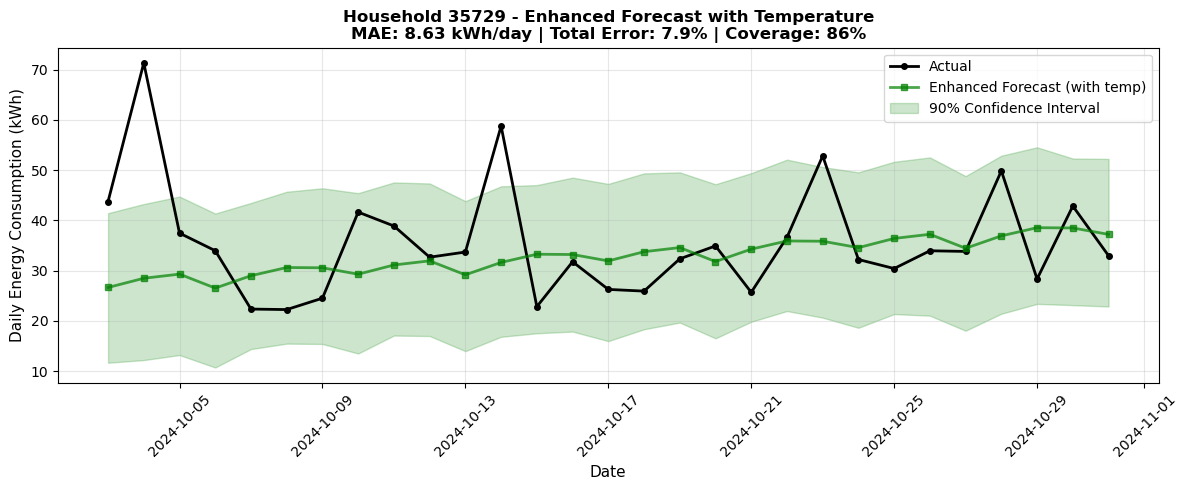

14:27:34 - cmdstanpy - INFO - Chain [1] start processing
14:27:34 - cmdstanpy - INFO - Chain [1] done processing



Processing household: 31089
  MAE: 2.94 kWh/day
  RMSE: 3.84 kWh/day
  Coverage Rate: 89.7%
  Total Error: 3.93 kWh (0.61%)


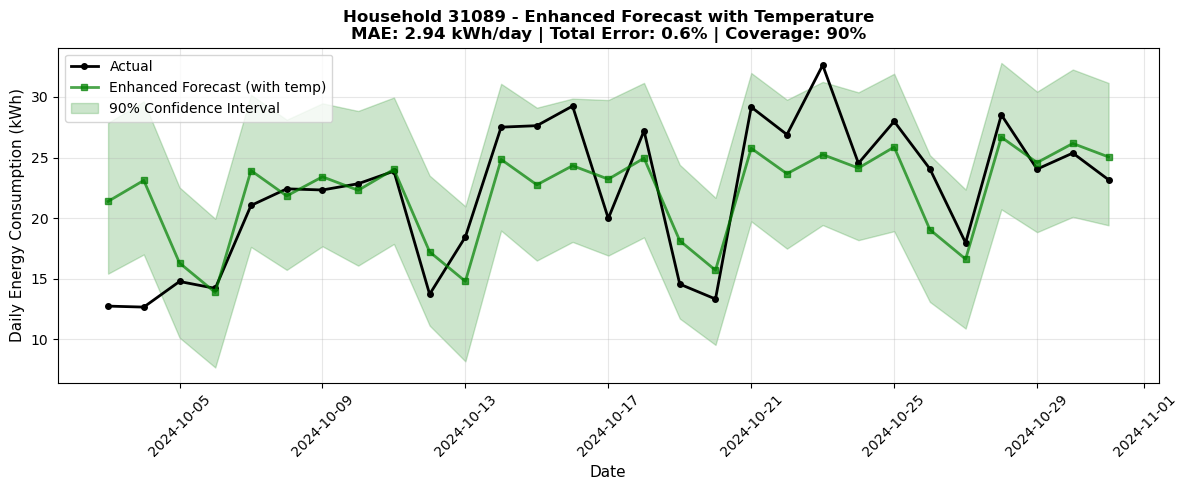


Processing household: 37728


14:27:34 - cmdstanpy - INFO - Chain [1] start processing
14:27:34 - cmdstanpy - INFO - Chain [1] done processing


  MAE: 14.23 kWh/day
  RMSE: 17.57 kWh/day
  Coverage Rate: 82.8%
  Total Error: 119.34 kWh (8.90%)


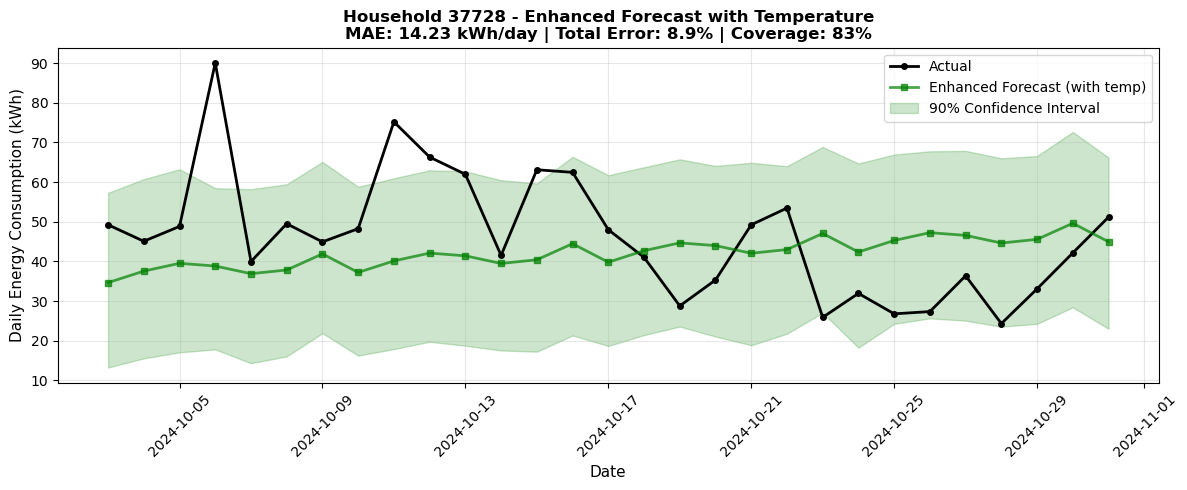


Processing household: 93973


14:27:34 - cmdstanpy - INFO - Chain [1] start processing
14:27:35 - cmdstanpy - INFO - Chain [1] done processing


  MAE: 11.41 kWh/day
  RMSE: 13.23 kWh/day
  Coverage Rate: 62.1%
  Total Error: -153.00 kWh (-21.24%)


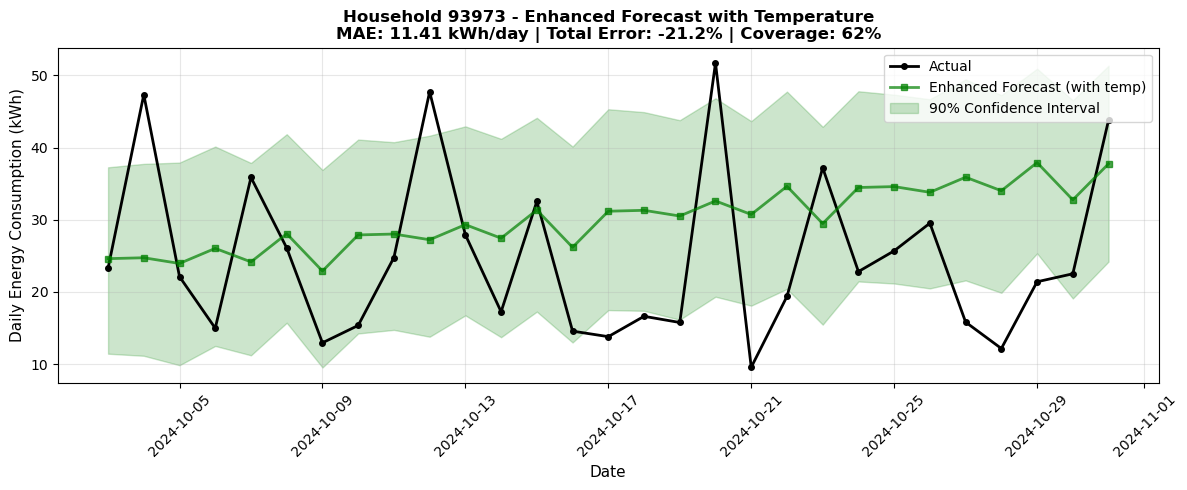


Processing household: 24099


14:27:35 - cmdstanpy - INFO - Chain [1] start processing
14:27:35 - cmdstanpy - INFO - Chain [1] done processing


  MAE: 2.58 kWh/day
  RMSE: 3.13 kWh/day
  Coverage Rate: 96.6%
  Total Error: 2.71 kWh (0.71%)


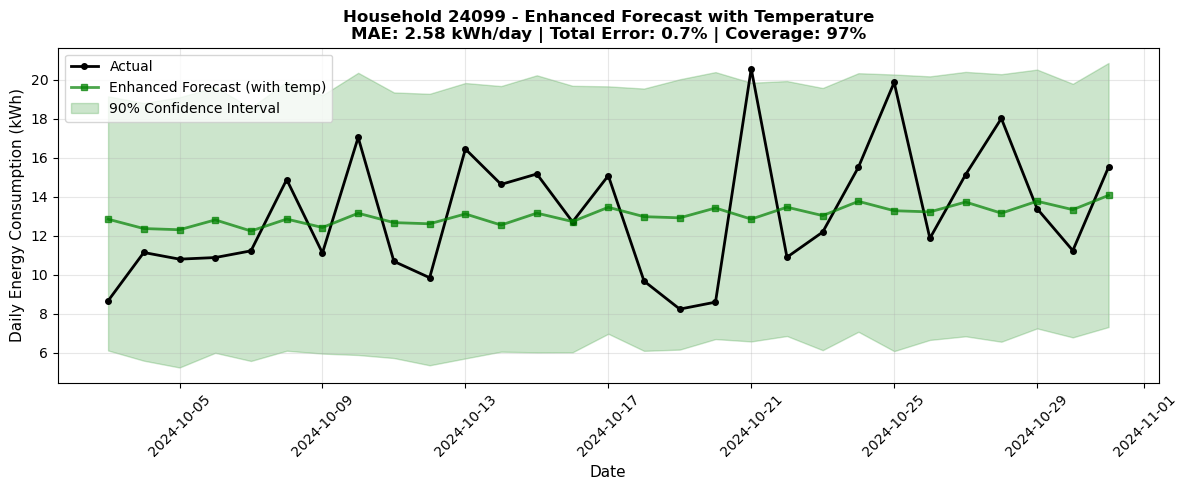

14:27:35 - cmdstanpy - INFO - Chain [1] start processing
14:27:35 - cmdstanpy - INFO - Chain [1] done processing



Processing household: 23852
  MAE: 2.23 kWh/day
  RMSE: 2.60 kWh/day
  Coverage Rate: 89.7%
  Total Error: -62.10 kWh (-39.90%)


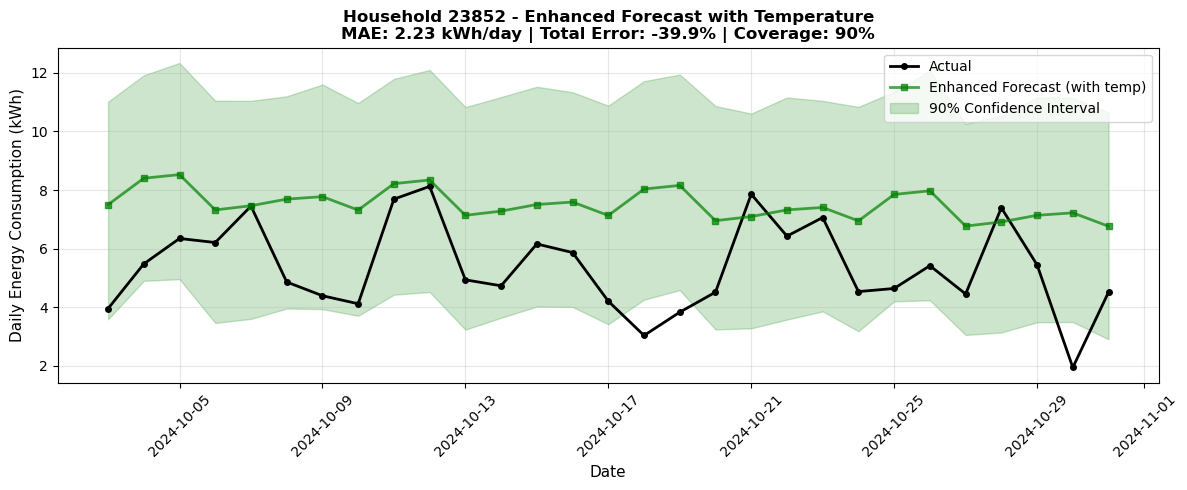


Processing household: 13332


14:27:35 - cmdstanpy - INFO - Chain [1] start processing
14:27:35 - cmdstanpy - INFO - Chain [1] done processing


  MAE: 8.34 kWh/day
  RMSE: 10.07 kWh/day
  Coverage Rate: 100.0%
  Total Error: -192.97 kWh (-17.05%)


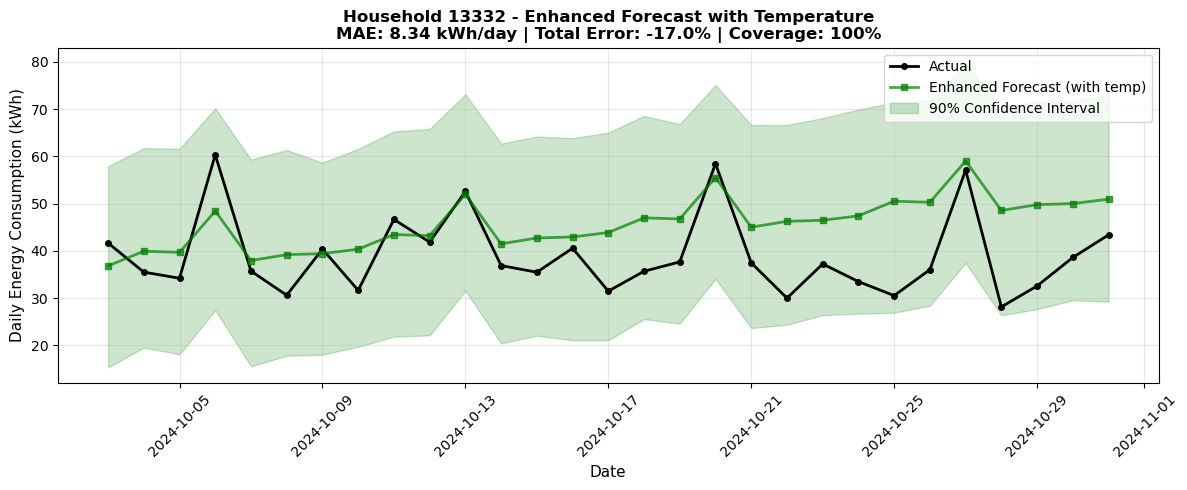

14:27:35 - cmdstanpy - INFO - Chain [1] start processing
14:27:35 - cmdstanpy - INFO - Chain [1] done processing



Processing household: 0.43
  MAE: 7.77 kWh/day
  RMSE: 10.44 kWh/day
  Coverage Rate: 100.0%
  Total Error: 51.05 kWh (5.59%)


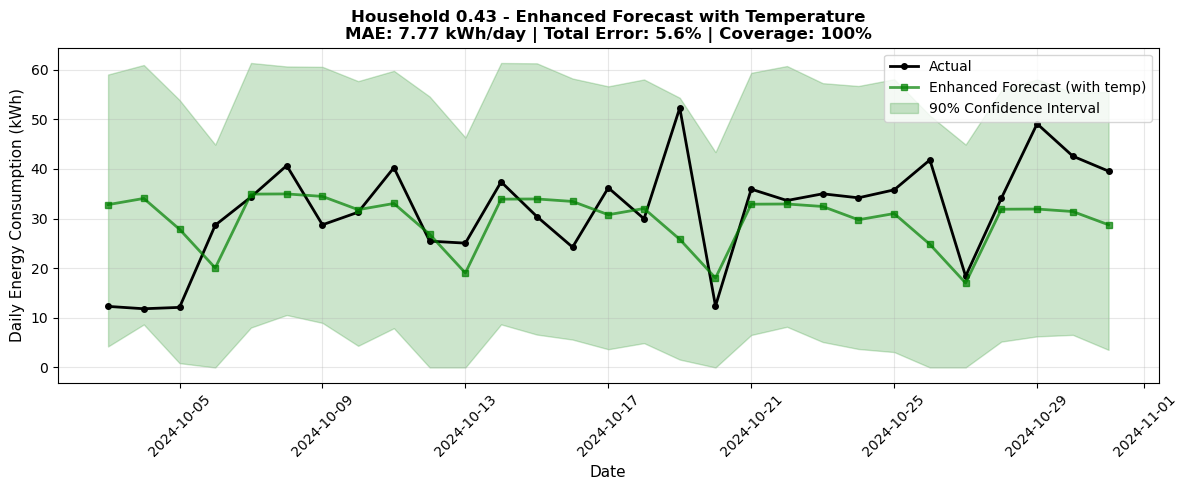


Processing household: 87782


14:27:36 - cmdstanpy - INFO - Chain [1] start processing
14:27:36 - cmdstanpy - INFO - Chain [1] done processing


  MAE: 2.03 kWh/day
  RMSE: 2.23 kWh/day
  Coverage Rate: 100.0%
  Total Error: -41.30 kWh (-46.45%)


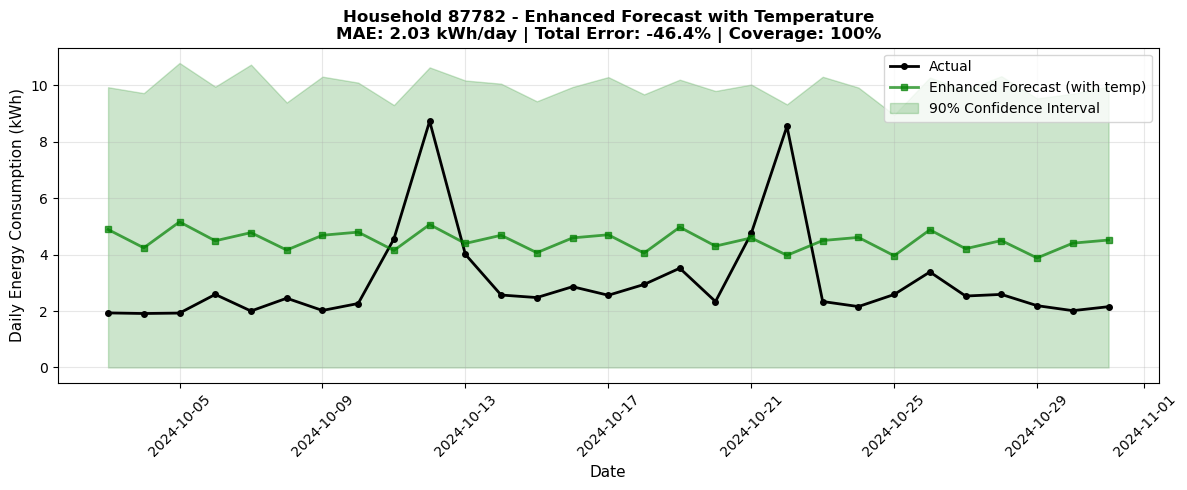

14:27:36 - cmdstanpy - INFO - Chain [1] start processing
14:27:36 - cmdstanpy - INFO - Chain [1] done processing



Processing household: 87814
  MAE: 17.26 kWh/day
  RMSE: 19.09 kWh/day
  Coverage Rate: 20.7%
  Total Error: -479.84 kWh (-50.74%)


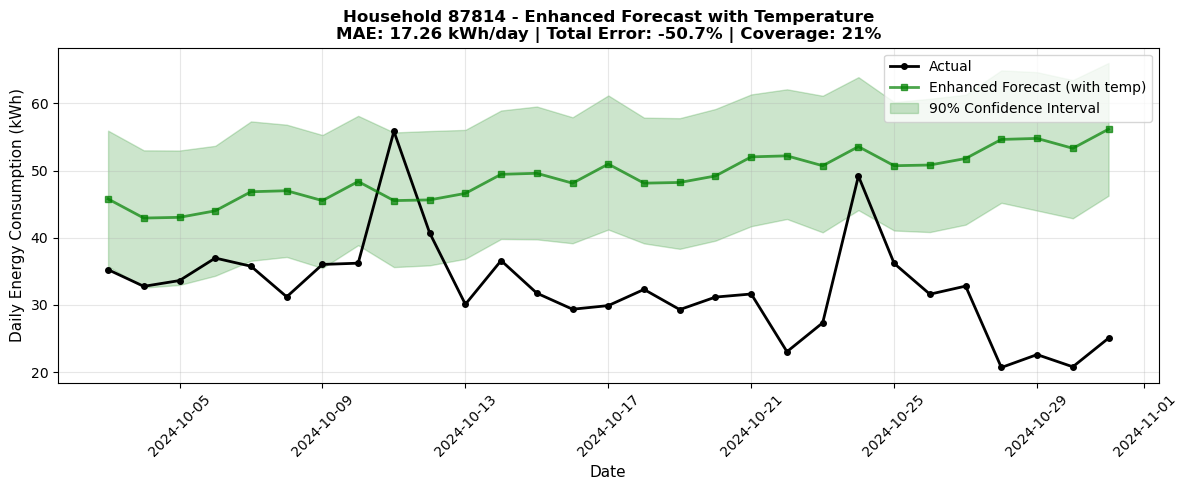


ENHANCED FORECASTING RESULTS

Number of households: 10

Average Metrics:
  Mean MAE: 7.74 kWh/day (±5.38)
  Mean RMSE: 9.44 kWh/day (±6.26)
  Mean Coverage Rate: 82.8%
  Mean Total Error: -15.16% (±23.43%)

DETAILED RESULTS


household_id    mae   rmse  coverage_rate  total_actual_kwh  \
8        87782   2.03   2.23         100.00             88.91   
5        23852   2.23   2.60          89.66            155.65   
4        24099   2.58   3.13          96.55            380.97   
1        31089   2.94   3.84          89.66            642.82   
7         0.43   7.77  10.44         100.00            913.68   
6        13332   8.34  10.07         100.00           1132.01   
0        35729   8.63  12.20          86.21           1034.80   
3        93973  11.41  13.23          62.07            720.43   
2        37728  14.23  17.57          82.76           1341.42   
9        87814  17.26  19.09          20.69            945.75   

   total_predicted_kwh  total_error_pct  
8               130.21           -46.45  
5               217.75           -39.90  
4               378.26             0.71  
1               638.90             0.61  
7               862.63             5.59  
6              1324.98           -17.05  
0               952.56             7.95  
3               873.44           -21.24  
2              1222.08             8.90  
9              1425.60           -50.74

In [15]:
# Test the enhanced forecasting method with temperature regressor
results_enhanced = []

print("Enhanced Forecasting with Temperature Regressor")
print("=" * 80)

for household_id in train_data.keys():
    print(f"\nProcessing household: {household_id}")
    
    try:
        # Get training and validation data
        train = train_data[household_id]
        validation = validation_data[household_id]
        
        # Forecast daily totals with temperature
        forecast, model = forecast_daily_total_energy_with_temp(
            train, 
            temperature_data, 
            forecast_days=validation_days
        )
        
        # Get only the forecasted period (future dates)
        forecast_start_date = train['datetime'].max() + pd.Timedelta(days=1)
        future_forecast = forecast[forecast['ds'] >= forecast_start_date].copy()
        
        # Aggregate validation data to daily totals for comparison
        validation_daily = validation.copy()
        validation_daily['datetime'] = pd.to_datetime(validation_daily['datetime'])
        validation_daily = validation_daily.set_index('datetime').resample('D')['value'].sum().reset_index()
        validation_daily.columns = ['ds', 'y']
        
        # Merge forecast with actual values
        comparison = pd.merge(
            validation_daily,
            future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
            on='ds',
            how='inner'
        )

        # Calculate metrics
        actual = comparison['y'].values
        predicted = comparison['yhat'].values
        
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        rmse = np.sqrt(mse)
        
        # Coverage rate
        lower_bounds = comparison['yhat_lower'].values
        upper_bounds = comparison['yhat_upper'].values
        within_interval = ((actual >= lower_bounds) & (actual <= upper_bounds)).sum()
        coverage_rate = (within_interval / len(actual)) * 100
        
        # Total energy comparison
        total_actual = actual.sum()
        total_predicted = predicted.sum()
        total_error = total_actual - total_predicted
        total_error_pct = (total_error / total_actual) * 100

        results_enhanced.append({
            'household_id': household_id,
            'mae': mae,
            'mse': mse,
            'rmse': rmse,
            'coverage_rate': coverage_rate,
            'total_actual_kwh': total_actual,
            'total_predicted_kwh': total_predicted,
            'total_error_kwh': total_error,
            'total_error_pct': total_error_pct,
            'n_days': len(comparison),
            'mean_daily_consumption': actual.mean(),
            'std_daily_consumption': actual.std()
        })
        
        print(f"  MAE: {mae:.2f} kWh/day")
        print(f"  RMSE: {rmse:.2f} kWh/day")
        print(f"  Coverage Rate: {coverage_rate:.1f}%")
        print(f"  Total Error: {total_error:.2f} kWh ({total_error_pct:.2f}%)")
        
        # Visualize
        fig, ax = plt.subplots(figsize=(12, 5))
        ax.plot(comparison['ds'], comparison['y'], 'o-', color='black', 
                label='Actual', linewidth=2, markersize=4)
        ax.plot(comparison['ds'], comparison['yhat'], 's-', color='green', 
                label='Enhanced Forecast (with temp)', linewidth=2, markersize=4, alpha=0.7)
        ax.fill_between(comparison['ds'], comparison['yhat_lower'], comparison['yhat_upper'],
                        alpha=0.2, color='green', label='90% Confidence Interval')
        
        ax.set_xlabel('Date', fontsize=11)
        ax.set_ylabel('Daily Energy Consumption (kWh)', fontsize=11)
        ax.set_title(f'Household {household_id} - Enhanced Forecast with Temperature\n'
                    f'MAE: {mae:.2f} kWh/day | Total Error: {total_error_pct:.1f}% | Coverage: {coverage_rate:.0f}%',
                    fontsize=12, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"  Error processing household {household_id}: {str(e)}")
        import traceback
        traceback.print_exc()
        continue

# Create results DataFrame
results_enhanced_df = pd.DataFrame(results_enhanced)

print("\n" + "=" * 80)
print("ENHANCED FORECASTING RESULTS")
print("=" * 80)
print(f"\nNumber of households: {len(results_enhanced_df)}")
print(f"\nAverage Metrics:")
print(f"  Mean MAE: {results_enhanced_df['mae'].mean():.2f} kWh/day (±{results_enhanced_df['mae'].std():.2f})")
print(f"  Mean RMSE: {results_enhanced_df['rmse'].mean():.2f} kWh/day (±{results_enhanced_df['rmse'].std():.2f})")
print(f"  Mean Coverage Rate: {results_enhanced_df['coverage_rate'].mean():.1f}%")
print(f"  Mean Total Error: {results_enhanced_df['total_error_pct'].mean():.2f}% (±{results_enhanced_df['total_error_pct'].std():.2f}%)")

print("\n" + "=" * 80)
print("DETAILED RESULTS")
print("=" * 80)
display(results_enhanced_df.sort_values('mae')[['household_id', 'mae', 'rmse', 'coverage_rate',
                                                  'total_actual_kwh', 'total_predicted_kwh', 
                                                  'total_error_pct']].round(2))